# 1) Install and Import Libraries

In [5]:
# Install BERTopic and contractions library
#!pip install bertopic[visualize]
#!pip install contractions

# Import necessary libraries
#from bertopic import BERTopic
#from bertopic.vectorizers import ClassTfidfTransformer
#from umap import UMAP
#from hdbscan import HDBSCAN
import pandas as pd
import numpy as np
import nltk
import contractions
import re

# 2) Download and Read Data

In [ ]:
# Mount to Drive
from google.colab import drive
drive.mount('/content/drive')

# Read the data from the CSV file
df = pd.read_csv('/content/drive/My Drive/Data/sentence_data_train_JO.csv')

# Extract the four-digit participant ID from the "filename" column and replace "filename" column
df['participant_ID'] = df['Filename'].apply(lambda x: re.search(r'\d{4}', x).group())
df.drop('Filename', axis=1, inplace=True)

# Preview the data to understand its structure
print(df.head())


Mounted at /content/drive
                                       Sentence_Text Scores participant_ID
0  I was born in 1947. In 1948, my parents bought...    102           2353
1                                              Yeah.    102           2353
2           So that's why I started earlier than 18.    102           2353
3  Yeah. Noise, whatever, for kids. So, anyway, h...    102           2353
4               I think we're probably in Chapter 3.    102           2353


# 3) Text Data Preprocessing

In [ ]:
import nltk
import re
# import contractions
from nltk.corpus import stopwords as nltk_stopwords

# Download and load the stopwords from NLTK
# nltk.download('stopwords')
# stopwords = nltk_stopwords.words('english')

# Add your custom stopwords to the list
### custom_stopwords = ['think', 'dont', 'know', 'like', 'um', 'yeah', 'im', 'get', 'uh',
                    #'thats', 'lot', 'ive', 'make', 'would', 'go', 'cause', 'gonna',
                    #'says', 'said', 'chapter', 'chapters', 'geopolitical', 'location', 'turning',
                    #'point', 'points', 'character', 'characters', 'okay', 'mhmm', 'oh', 'mmm', 'hmm', 'yep',
                    #'organization', 'person',
                    #'huh', 'mmhmm',
                    #'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven',
                    #'first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh', 'eigth', 'ninth', 'tenth', 'eleventh',
                    #'best', 'worst', 'high', 'low',
                    #'influence', 'influences', 'negative', 'positive',
                    #'signature', 'form', 'title', 'indicates', 'titled',
                    #'interviewer', 'interviewee']
### stopwords.extend(custom_stopwords)

# Define the function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Expand contractions (e.g., "don't" to "do not")
    ### text = contractions.fix(text)
    # Remove non-alphanumeric characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    ### text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

# Apply the preprocessing function to the text
df['preprocessed_text'] = df['Sentence_Text'].astype(str).apply(preprocess_text)

# Filter out short sentences with less than 3 words
df = df[df['preprocessed_text'].str.split().str.len() >= 3]

# Check the first few entries of the preprocessed text
print(df['preprocessed_text'].head())


0    i was born in  in  my parents bought a farm wh...
2                 so thats why i started earlier than 
3    yeah noise whatever for kids so anyway had abo...
4                    i think were probably in chapter 
5    then in  i decided i needed to get a masters i...
Name: preprocessed_text, dtype: object


# 4) Topic Modeling

In [ ]:
from bertopic.vectorizers import ClassTfidfTransformer

# Set UMAP and HDBScan parameters

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', prediction_data=True)

# Initialize ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Create a BERTopic model with UMAP, HDBSCAN, and ClassTfidfTransformer
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    language="english",
    calculate_probabilities = True
)

# Fit the model to the preprocessed text
topics, probs = topic_model.fit_transform(df['preprocessed_text'])

# Get an overview of the topics
topic_info = topic_model.get_topic_info()
print(topic_info.head())

In [ ]:
# Save the BERTopic Model created in Step 4 above

# Specify the embedding model
embedding_model = "sentence-transformers/all-MiniLM-L6-v2"

# Save the model with custom settings
topic_model.save('/content/drive/My Drive/Data/BERTopic_model',
                 serialization="safetensors",
                 save_embedding_model=embedding_model,
                 save_ctfidf=True)

## NOTE: Also save the merged_df dataframe that is created during Step 5 below.

In [ ]:
# Load the BERTopic Model

# Load the model
loaded_topic_model = BERTopic.load('/content/drive/My Drive/Data/BERTopic_model', serialization="safetensors")

# Load the merged DataFrame *** NOTE: This is/was created in Step 5 below ***
merged_df = pd.read_csv('/content/drive/My Drive/Data/merged_topic_personality_scores.csv')

In [ ]:
# Get the full list of topics and their counts
topic_info = topic_model.get_topic_info()

# Display the full list of topics and their counts
print(topic_info)

# Optionally, save the topics and counts to a CSV file
topic_info.to_csv('topic_info.csv', index=False)

     Topic  Count                                        Name  \
0       -1  22247               -1_money_worked_married_house   
1        0    962            0_church_catholic_bible_seminary   
2        1    686             1_vietnam_military_army_drafted   
3        2    564                 2_husband_dad_father_mother   
4        3    468                3_chapter_chapters_end_limbo   
..     ...    ...                                         ...   
170    169     16                     169_edit_gee_saying_why   
171    170     16    170_therapy_objectives_counseling_wander   
172    171     15       171_alderman_candidacy_election_mayor   
173    172     15  172_computer_analyst_programming_computers   
174    173     15   173_tattooed_hiphop_tattoos_granddaughter   

                                        Representation  \
0    [money, worked, married, house, moved, kids, w...   
1    [church, catholic, bible, seminary, god, pasto...   
2    [vietnam, military, army, drafted, draft

In [ ]:
# Display the probabilities
print(probs)

[[0.00056461 0.00080806 0.00052592 ... 0.00030253 0.00129395 0.00210266]
 [0.00131215 0.00184216 0.00115759 ... 0.00595272 0.00148739 0.00140071]
 [0.00500593 0.0051597  0.00544637 ... 0.00190482 0.00408153 0.00382081]
 ...
 [0.00166903 0.00231925 0.00163606 ... 0.00195724 0.00189967 0.00177141]
 [0.00017036 0.00025399 0.00015545 ... 0.00198014 0.00020913 0.00019648]
 [0.00044101 0.00064971 0.0004259  ... 0.00063796 0.00051879 0.00048086]]


In [ ]:
# Convert probabilities to a DataFrame
probs_df = pd.DataFrame(probs)

# Display the first few rows of the DataFrame
print(probs_df.head())

        0         1         2         3         4         5         6    \
0  0.006074  0.002361  0.002060  0.006325  0.004772  0.002913  0.021790   
1  0.001519  0.001008  0.001128  0.001740  0.001682  0.002372  0.001881   
2  0.004519  0.004031  0.002414  0.002067  0.002381  0.003397  0.002536   
3  0.001161  0.001762  0.747882  0.001097  0.000926  0.001338  0.001128   
4  0.004448  0.006594  0.003241  0.002303  0.002700  0.004293  0.002892   

        7         8         9    ...       165       166       167       168  \
0  0.007735  0.002697  0.005298  ...  0.002798  0.002513  0.013599  0.002886   
1  0.001326  0.001097  0.002204  ...  0.009017  0.005491  0.001488  0.001213   
2  0.002917  0.005056  0.002401  ...  0.001843  0.001714  0.003174  0.004888   
3  0.001049  0.001615  0.001291  ...  0.001031  0.000962  0.001226  0.001610   
4  0.003023  0.006186  0.002696  ...  0.002151  0.002014  0.003616  0.007377   

        169       170       171       172       173       174  
0  0

In [ ]:
# Save the probabilities to a CSV file
probs_df.to_csv('topic_probabilities.csv', index=False)

In [7]:
df=pd.read_csv('transcript_topic_probabilities_with_PARTID.csv',header=0)

In [8]:
df.shape

(37297, 151)

In [9]:
df.head()

0         1         2         3         4         5         6  \
0  0.000211  0.001047  0.001171  0.000229  0.000518  0.000602  0.001209   
1  0.000800  0.001996  0.002554  0.000647  0.001042  0.000833  0.003981   
2  0.004068  0.008353  0.004546  0.004492  0.002141  0.003092  0.128512   
3  0.337530  0.006471  0.006636  0.004693  0.002488  0.003097  0.020324   
4  0.005289  0.006223  0.004202  0.005088  0.001856  0.002609  0.044897   

          7         8         9  ...       141       142       143       144  \
0  0.001095  0.000815  0.003604  ...  0.000267  0.000191  0.000959  0.000365   
1  0.002936  0.002432  0.001119  ...  0.000885  0.003138  0.001137  0.001048   
2  0.019427  0.029588  0.002414  ...  0.005611  0.001546  0.003390  0.005541   
3  0.017842  0.014246  0.003112  ...  0.004468  0.002562  0.003400  0.004233   
4  0.018641  0.029227  0.002190  ...  0.009330  0.001535  0.002902  0.005515   

        145       146       147       148  participant_ID  \
0  0.000214  0.000210  0.000202  0.000240            2353   
1  0.002619  0.002755  0.002969  0.001643            2353   
2  0.001653  0.001655  0.001656  0.003301            2353   
3  0.002565  0.002497  0.002501  0.003498            2353   
4  0.001626  0.001606  0.001597  0.003390            2353   

                                       document_text  
0  i was born in  in  my parents bought a farm wh...  
1             so that is why i started earlier than   
2  yeah noise whatever for kids so anyway had abo...  
3                i think we are probably in chapter   
4  then in  i decided i needed to get a masters i...  

[5 rows x 151 columns]

# 5) Aggregate Probabilities and Merge with Personality Data

In [10]:
# Load the personality scores dataset
personality_scores_df = pd.read_csv('NEO_Baseline_domainsonly.csv')

# Ensure participant_ID is a string and trimmed
df['participant_ID'] = df['participant_ID'].astype(str).str.strip()

# Ensure PARTID is a string and trimmed
personality_scores_df['PARTID'] = personality_scores_df['PARTID'].astype(str).str.strip()

# Check for unique IDs in both DataFrames
print("Unique IDs in df['participant_ID'] (first 20):", df['participant_ID'].unique()[:20])
print("Unique IDs in personality_scores_df['PARTID'] (first 20):", personality_scores_df['PARTID'].unique()[:20])

Unique IDs in df['participant_ID'] (first 20): ['2353' '3330' '4532' '4177' '3459' '3389' '2304' '3112' '3235' '3368'
 '2131' '2097' '2419' '3111' '3427' '4128' '3343' '2362' '2091' '3023']
Unique IDs in personality_scores_df['PARTID'] (first 20): ['1001' '1002' '1003' '1004' '1005' '1006' '1007' '1008' '1009' '1010'
 '1011' '1012' '1013' '1014' '1015' '1016' '1017' '1018' '1019' '1020']


In [141]:
# Filter the personality scores dataframe to include only participants present in the text dataframe
filtered_personality_scores_df = personality_scores_df[personality_scores_df['PARTID'].isin(df['participant_ID'])]

# Check if there are matching IDs before merging
matching_ids = set(filtered_personality_scores_df['PARTID']).intersection(set(df['participant_ID']))
print("Matching IDs:", len(matching_ids))

Matching IDs: 1124


In [154]:
probs_df =df.iloc[:,0:150]

In [156]:
# Aggregate probabilities for each participant
topic_probabilities = probs_df.groupby('participant_ID').max()

In [162]:
topic_probabilities

0         1         2         3         4         5  \
participant_ID                                                               
1002            0.361508  0.082673  0.013152  0.005520  1.000000  0.006924   
1004            0.288058  0.017912  0.010925  0.006471  0.233267  0.207520   
1007            0.248013  0.012774  0.012616  0.007884  0.013020  0.007991   
1008            0.760558  0.051096  0.148577  0.005867  0.056968  0.025481   
1009            1.000000  1.000000  0.013041  0.020204  0.038758  0.016136   
1012            0.002547  0.008174  1.000000  0.002230  0.089490  0.004204   
1014            0.111840  0.014105  0.238631  0.009836  0.137779  0.012797   
1015            0.600192  0.011775  0.010077  0.003457  0.243471  0.007934   
1016            0.005887  0.010381  0.051576  0.004498  0.010087  0.016096   
1017            0.147467  0.202993  0.008647  0.009410  0.033290  0.007193   
1018            1.000000  0.011923  0.242036  0.007506  0.009305  0.007202   
1020            0.009818  0.010171  0.012936  0.008516  0.226935  0.006133   
1021            0.339714  0.008965  0.026128  0.008923  0.022818  0.004225   
1022            0.341229  1.000000  0.300395  0.008343  0.044542  0.142729   
1024            0.005992  0.013950  0.314496  0.005593  0.048195  0.006552   
1026            1.000000  0.010357  1.000000  0.009390  0.174032  0.004519   
1027            0.421480  0.013586  1.000000  0.262551  0.014083  0.006193   
1028            0.349717  0.010467  0.010245  0.006723  0.228572  0.004929   
1031            0.504216  0.010966  0.015206  0.005035  1.000000  0.005392   
1032            0.008848  0.013077  0.007400  0.007307  0.011408  0.011227   
1035            0.323388  0.012563  0.652582  0.007482  0.012441  0.015841   
1037            1.000000  0.013963  0.027912  0.005878  0.428939  0.009156   
1042            0.050251  0.014921  0.054769  0.012418  0.160405  0.017224   
1044            0.004612  0.010937  0.010131  0.003977  0.136348  0.005509   
1048            0.556852  0.229925  0.175923  0.023690  0.055786  0.012258   
1051            0.443121  0.011993  0.022318  0.006218  0.010906  0.005882   
1053            0.007315  0.012518  0.013407  0.008113  0.030629  0.007372   
1054            1.000000  0.016573  0.014265  0.005344  0.304570  0.012188   
1056            0.348980  0.011718  0.502619  0.149229  0.008940  0.014002   
1057            0.294683  0.021591  0.021149  0.356254  0.012024  0.085418   
1059            0.107164  0.170716  0.094052  0.009948  0.044680  0.008490   
1061            1.000000  0.010575  0.013351  0.008729  0.047245  0.004736   
1062            0.564713  0.165389  0.431576  0.010355  0.033353  0.124800   
1063            1.000000  0.173831  0.025163  0.009641  0.243642  0.044402   
1064            0.234591  0.352945  0.127711  0.011381  0.109033  0.050048   
1065            1.000000  0.013571  0.801026  0.347411  0.165250  0.004288   
1066            1.000000  0.010553  1.000000  1.000000  0.418827  0.006625   
1068            1.000000  0.009084  0.022988  0.103437  0.146918  0.004472   
1069            1.000000  0.015686  0.017054  0.030124  0.007986  0.010634   
1070            0.009817  0.011344  1.000000  0.027699  0.023078  0.006013   
1071            1.000000  0.045364  0.008837  0.010442  0.011099  0.004400   
1072            0.554309  0.012577  0.328034  0.009637  0.017639  1.000000   
1073            0.241157  0.044939  0.350920  0.006232  0.275945  0.010749   
1074            1.000000  1.000000  0.011020  0.009266  0.004522  0.010749   
1075            1.000000  0.010661  0.009572  0.007966  0.107915  0.007010   
1076            1.000000  1.000000  0.383009  0.008649  0.136378  0.013801   
1077            1.000000  0.187307  0.010512  0.007004  0.004721  0.173374   
1078            1.000000  0.016321  0.376316  0.008148  0.004757  0.013046   
1079            0.159491  0.013211  1.000000  0.009297  0.006409  0.006363   
1081            1.000000  0.019488  0.010169 

In [163]:
# Aggregate probabilities for each participant
topic_probabilities = probs_df.groupby('participant_ID').max()

# Ensure that the participant_ID column is a string in both DataFrames
topic_probabilities.index = topic_probabilities.index.astype(str)

# Merge the aggregated probabilities with the filtered personality scores
merged_df = topic_probabilities.merge(filtered_personality_scores_df, left_index=True, right_on='PARTID')

# Verify the merged dataframe
print("Merged DataFrame (first 5 rows):\n", merged_df.head())
print("Shape of Merged DataFrame:", merged_df.shape)

Merged DataFrame (first 5 rows):
           0         1         2         3         4         5         6  \
1  0.361508  0.082673  0.013152  0.005520  1.000000  0.006924  0.216859   
3  0.288058  0.017912  0.010925  0.006471  0.233267  0.207520  0.046636   
6  0.248013  0.012774  0.012616  0.007884  0.013020  0.007991  1.000000   
7  0.760558  0.051096  0.148577  0.005867  0.056968  0.025481  0.033404   
8  1.000000  1.000000  0.013041  0.020204  0.038758  0.016136  0.043495   

          7         8         9  ...       145       146       147       148  \
1  0.021029  0.016931  0.008138  ...  0.004416  0.006402  0.007819  0.028163   
3  0.052662  0.029315  0.008729  ...  0.007843  0.019287  0.021829  0.045290   
6  0.618590  0.118891  0.016452  ...  0.007255  0.021024  0.021159  0.006050   
7  0.048217  0.040671  0.153831  ...  0.007263  0.014464  0.018780  0.004371   
8  0.134860  0.063245  0.028207  ...  0.006683  0.009715  0.009340  0.004166   

   PARTID  PNEON_scaled  PNEOE_sca

In [164]:
# Save the merged DataFrame to a CSV file if needed **** NEED THIS TO LOAD SAVED MODEL LATER *****
merged_df.to_csv('merged_topic_personality_scores.csv', index=False)

# Convert non-numeric values to NaN
cleaned_df = merged_df.apply(pd.to_numeric, errors='coerce')
#rows_with_na = cleaned_df[cleaned_df.isna().any(axis=1)]
# Identify columns with NaN values and the count of NaNs
na_columns = cleaned_df.isna().sum()
na_columns = na_columns[na_columns > 0]
print("Columns with NaN values and their count:\n", na_columns)

Columns with NaN values and their count:
 PNEON_scaled    21
PNEOE_scaled    23
PNEOO_scaled    27
PNEOA_scaled    23
PNEOC_scaled    24
dtype: int64


In [165]:
# Check the number of rows with NaN values
rows_with_na = cleaned_df.isna().sum(axis=1)
num_rows_with_na = (rows_with_na > 0).sum()
print(f"Total number of rows: {cleaned_df.shape[0]}")
print(f"Number of rows with NaN values: {num_rows_with_na}")
print(f"Number of rows remaining after dropping NaNs: {cleaned_df.shape[0] - num_rows_with_na}")

# Optionally, display the rows containing NaN values
rows_with_na = cleaned_df[cleaned_df.isna().any(axis=1)]
print("Rows with NaN values:\n", rows_with_na)

# Total number of rows before dropping
total_rows = cleaned_df.shape[0]

# Drop rows with NaN values
cleaned_df.dropna(inplace=True)

Total number of rows: 1124
Number of rows with NaN values: 29
Number of rows remaining after dropping NaNs: 1095
Rows with NaN values:
              0         1         2         3         4         5         6  \
218   0.007389  0.019478  0.634636  0.007833  0.007717  0.164899  0.045127   
245   0.180396  1.000000  0.012005  0.006591  0.069400  0.009408  0.028734   
274   0.234684  0.016796  0.465746  0.005701  0.088857  1.000000  0.023752   
281   0.132654  0.017600  0.012157  0.006554  0.023007  1.000000  1.000000   
282   0.507652  0.017658  0.106865  0.727589  0.180985  0.184431  1.000000   
342   1.000000  1.000000  0.010938  0.210232  0.014485  0.026963  0.127415   
370   0.192543  0.010510  0.181052  0.006012  0.012184  0.006030  0.040565   
409   0.007156  0.093862  0.010726  0.008042  1.000000  0.070358  0.107575   
413   0.007215  0.066411  0.349079  0.120344  0.011276  0.460537  0.088411   
471   0.354046  0.011633  0.106554  0.009875  0.118480  0.004816  0.049800   
475   

In [166]:
cleaned_df

0         1         2         3         4         5         6  \
1     0.361508  0.082673  0.013152  0.005520  1.000000  0.006924  0.216859   
3     0.288058  0.017912  0.010925  0.006471  0.233267  0.207520  0.046636   
6     0.248013  0.012774  0.012616  0.007884  0.013020  0.007991  1.000000   
7     0.760558  0.051096  0.148577  0.005867  0.056968  0.025481  0.033404   
8     1.000000  1.000000  0.013041  0.020204  0.038758  0.016136  0.043495   
11    0.002547  0.008174  1.000000  0.002230  0.089490  0.004204  0.015223   
13    0.111840  0.014105  0.238631  0.009836  0.137779  0.012797  0.131303   
14    0.600192  0.011775  0.010077  0.003457  0.243471  0.007934  0.023384   
15    0.005887  0.010381  0.051576  0.004498  0.010087  0.016096  0.021568   
16    0.147467  0.202993  0.008647  0.009410  0.033290  0.007193  0.038429   
17    1.000000  0.011923  0.242036  0.007506  0.009305  0.007202  0.035852   
19    0.009818  0.010171  0.012936  0.008516  0.226935  0.006133  0.054859   
20    0.339714  0.008965  0.026128  0.008923  0.022818  0.004225  0.040747   
21    0.341229  1.000000  0.300395  0.008343  0.044542  0.142729  0.088490   
23    0.005992  0.013950  0.314496  0.005593  0.048195  0.006552  0.034477   
25    1.000000  0.010357  1.000000  0.009390  0.174032  0.004519  0.036058   
26    0.421480  0.013586  1.000000  0.262551  0.014083  0.006193  0.109640   
27    0.349717  0.010467  0.010245  0.006723  0.228572  0.004929  0.030210   
30    0.504216  0.010966  0.015206  0.005035  1.000000  0.005392  0.036060   
31    0.008848  0.013077  0.007400  0.007307  0.011408  0.011227  0.314629   
34    0.323388  0.012563  0.652582  0.007482  0.012441  0.015841  0.043978   
36    1.000000  0.013963  0.027912  0.005878  0.428939  0.009156  0.109062   
41    0.050251  0.014921  0.054769  0.012418  0.160405  0.017224  0.038047   
43    0.004612  0.010937  0.010131  0.003977  0.136348  0.005509  0.031220   
47    0.556852  0.229925  0.175923  0.023690  0.055786  0.012258  0.111561   
50    0.443121  0.011993  0.022318  0.006218  0.010906  0.005882  0.036562   
52    0.007315  0.012518  0.013407  0.008113  0.030629  0.007372  0.512575   
53    1.000000  0.016573  0.014265  0.005344  0.304570  0.012188  0.086567   
55    0.348980  0.011718  0.502619  0.149229  0.008940  0.014002  0.077740   
56    0.294683  0.021591  0.021149  0.356254  0.012024  0.085418  0.114008   
58    0.107164  0.170716  0.094052  0.009948  0.044680  0.008490  0.048743   
60    1.000000  0.010575  0.013351  0.008729  0.047245  0.004736  0.037626   
61    0.564713  0.165389  0.431576  0.010355  0.033353  0.124800  0.091282   
62    1.000000  0.173831  0.025163  0.009641  0.243642  0.044402  0.040813   
63    0.234591  0.352945  0.127711  0.011381  0.109033  0.050048  0.036909   
64    1.000000  0.013571  0.801026  0.347411  0.165250  0.004288  0.089318   
65    1.000000  0.010553  1.000000  1.000000  0.418827  0.006625  0.088389   
67    1.000000  0.009084  0.022988  0.103437  0.146918  0.004472  0.104687   
68    1.000000  0.015686  0.017054  0.030124  0.007986  0.010634  0.104347   
69    0.009817  0.011344  1.000000  0.027699  0.023078  0.006013  0.033853   
70    1.000000  0.045364  0.008837  0.010442  0.011099  0.004400  0.206741   
71    0.554309  0.012577  0.328034  0.009637  0.017639  1.000000  0.086776   
72    0.241157  0.044939  0.350920  0.006232  0.275945  0.010749  0.615989   
73    1.000000  1.000000  0.011020  0.009266  0.004522  0.010749  1.000000   
74    1.000000  0.010661  0.009572  0.007966  0.107915  0.007010  0.045140   
75    1.000000  1.000000  0.383009  0.008649  0.136378  0.013801  0.029462   
76    1.000000  0.187307  0.010512  0.007004  0.004721  0.173374  0.095605   
77    1.000000  0.016321  0.376316  0.008148  0.004757  0.013046  0.373106   
78    0.159491  0.013211  1.000000  0.009297  0.006409  0.006363  0.037209   
80    1.000000  0.019488  0.010169  0.008601  0.014279  0.005686  0.183404   
81    0.281108  0.009229  1.000000 

# 6) Correlate Topic Probabilities with Personality Traits

In [172]:
disorder_df=pd.read_csv('150_merged_topic_personality_scores.csv',header=0)

In [183]:
cleaned_df.head()

PARTID  SIDPOCC  SIDPBDC  SIDPSZC         0         1         2         3  \
0    1002      2.0      0.0      0.0  0.361508  0.082673  0.013152  0.005520   
1    1004      0.0      2.0      1.0  0.288058  0.017912  0.010925  0.006471   
2    1007      2.0      0.0      0.0  0.248013  0.012774  0.012616  0.007884   
3    1008      2.0      1.0      0.0  0.760558  0.051096  0.148577  0.005867   
4    1009      0.0      0.0      0.0  1.000000  1.000000  0.013041  0.020204   

          4         5  ...       144       145       146       147       148  \
0  1.000000  0.006924  ...  0.005356  0.004416  0.006402  0.007819  0.028163   
1  0.233267  0.207520  ...  0.016176  0.007843  0.019287  0.021829  0.045290   
2  0.013020  0.007991  ...  0.011033  0.007255  0.021024  0.021159  0.006050   
3  0.056968  0.025481  ...  0.008976  0.007263  0.014464  0.018780  0.004371   
4  0.038758  0.016136  ...  0.031016  0.006683  0.009715  0.009340  0.004166   

   PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled  
0          58.0         129.0         202.5         133.0         125.0  
1          89.0          99.0         122.0         123.0         117.0  
2          73.0         144.0         147.0         146.0         100.0  
3          80.4         124.8         148.8         152.4         129.6  
4          71.0         120.0         117.0         121.0         110.0  

[5 rows x 158 columns]

In [177]:
disorder_df.head()

0         1         2         3         4         5         6  \
0  0.002281  0.024276  0.004972  0.002473  0.002058  0.002989  0.015232   
1  0.011803  0.013566  0.007551  0.002177  0.002589  0.003721  0.010961   
2  0.022340  0.004581  0.024065  0.001933  0.024330  0.002347  0.032287   
3  0.031581  0.005311  0.036843  0.002460  0.011896  0.019567  0.011686   
4  0.023759  0.006360  0.004151  0.099727  0.005838  0.005647  0.035506   

          7         8         9  ...       148  PARTID  PNEON_scaled  \
0  0.010882  0.013013  0.053106  ...  0.002319    1002            58   
1  0.010149  0.008447  0.002954  ...  0.001827    1004            89   
2  0.010486  0.031529  0.002583  ...  0.023172    1007            73   
3  0.015274  0.008306  0.003962  ...  0.003244    1008          80.4   
4  0.017573  0.017687  0.002713  ...  0.002276    1009            71   

   PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled  SIDPOCC  SIDPBDC  \
0           129         202.5           133           125        2        0   
1            99           122           123           117        0        2   
2           144           147           146           100        2        0   
3         124.8         148.8         152.4         129.6        2        1   
4           120           117           121           110        0        0   

   SIDPSZC  
0        0  
1        1  
2        0  
3        0  
4        0  

[5 rows x 158 columns]

In [178]:
disorder_df.shape

(1023, 158)

In [180]:
cleaned_df.shape

(1095, 158)

In [179]:
cleaned_df=pd.merge(disorder_df[['PARTID','SIDPOCC', 'SIDPBDC', 'SIDPSZC']],cleaned_df,how='right',on='PARTID')

In [184]:
# Correlation analysis: Correlate topic probabilities with personality traits
import seaborn as sns
import matplotlib.pyplot as plt
cols_all=cleaned_df.columns.tolist()
# Select topic probabilities and personality scores for correlation analysis
topic_columns = cols_all[4:153]
personality_columns = ['PNEON_scaled', 'PNEOE_scaled', 'PNEOO_scaled', 'PNEOA_scaled', 'PNEOC_scaled','SIDPOCC', 'SIDPBDC', 'SIDPSZC']

In [243]:
personality_columns = ['PNEON_scaled', 'PNEOE_scaled', 'PNEOO_scaled', 'PNEOA_scaled', 'PNEOC_scaled','SIDPOC', 'SIDPBD', 'SIDPSZ']

In [168]:
cols

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '40',
 '42',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '56',
 '57',
 '60',
 '63',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '73',
 '74',
 '76',
 '77',
 '78',
 '80',
 '81',
 '82',
 '83',
 '84',
 '87',
 '89',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '101',
 '104',
 '106',
 '109',
 '110',
 '111',
 '116',
 '117',
 '118',
 '119',
 '121',
 '122',
 '124',
 '125',
 '127',
 '128',
 '129',
 '130',
 '131',
 '134',
 '135',
 '136',
 '139',
 '140',
 '141',
 '143',
 '144',
 '145',
 '148',
 'PARTID',
 'PNEON_scaled',
 'PNEOE_scaled',
 'PNEOO_scaled',
 'PNEOA_scaled',
 'PNEOC_scaled',
 'SIDPOCC',
 'SIDPBDC',
 'SIDPSZC']

In [185]:
topic_columns

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [86]:
cols.remove('147')

In [93]:
cols[0:109]

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '40',
 '42',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '56',
 '57',
 '60',
 '63',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '73',
 '74',
 '76',
 '77',
 '78',
 '80',
 '81',
 '82',
 '83',
 '84',
 '87',
 '89',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '101',
 '104',
 '106',
 '109',
 '110',
 '111',
 '116',
 '117',
 '118',
 '119',
 '121',
 '122',
 '124',
 '125',
 '127',
 '128',
 '129',
 '130',
 '131',
 '134',
 '135',
 '136',
 '139',
 '140',
 '141',
 '143',
 '144',
 '145',
 '148']

In [240]:
cleaned_df_new[topic_columns + personality_columns] = cleaned_df_new[topic_columns + personality_columns].apply(pd.to_numeric, errors='coerce')


In [187]:
missing_values = merged_all_df[topic_columns + personality_columns].isna().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 0               0
1               0
2               0
3               0
4               0
5               0
6               0
7               0
8               0
9               0
10              0
11              0
12              0
13              0
14              0
15              0
16              0
17              0
18              0
19              0
20              0
21              0
22              0
23              0
24              0
25              0
26              0
27              0
28              0
29              0
30              0
31              0
32              0
33              0
34              0
35              0
36              0
37              0
38              0
39              0
40              0
41              0
42              0
43              0
44              0
45              0
46              0
47              0
48              0
49              0
50              0
51              0
52              0
53              0


In [188]:
cleaned_df

PARTID  SIDPOCC  SIDPBDC  SIDPSZC         0         1         2  \
0       1002      2.0      0.0      0.0  0.361508  0.082673  0.013152   
1       1004      0.0      2.0      1.0  0.288058  0.017912  0.010925   
2       1007      2.0      0.0      0.0  0.248013  0.012774  0.012616   
3       1008      2.0      1.0      0.0  0.760558  0.051096  0.148577   
4       1009      0.0      0.0      0.0  1.000000  1.000000  0.013041   
5       1012      2.0      2.0      0.0  0.002547  0.008174  1.000000   
6       1014      3.0      0.0      0.0  0.111840  0.014105  0.238631   
7       1015      3.0      0.0      1.0  0.600192  0.011775  0.010077   
8       1016      3.0      0.0      3.0  0.005887  0.010381  0.051576   
9       1017      1.0      0.0      0.0  0.147467  0.202993  0.008647   
10      1018      1.0      1.0      1.0  1.000000  0.011923  0.242036   
11      1020      2.0      0.0      0.0  0.009818  0.010171  0.012936   
12      1021      0.0      0.0      0.0  0.339714  0.008965  0.026128   
13      1022      1.0      0.0      0.0  0.341229  1.000000  0.300395   
14      1024      2.0      0.0      1.0  0.005992  0.013950  0.314496   
15      1026      NaN      NaN      NaN  1.000000  0.010357  1.000000   
16      1027      3.0      0.0      0.0  0.421480  0.013586  1.000000   
17      1028      1.0      0.0      0.0  0.349717  0.010467  0.010245   
18      1031      0.0      0.0      1.0  0.504216  0.010966  0.015206   
19      1032      0.0      0.0      0.0  0.008848  0.013077  0.007400   
20      1035      2.0      1.0      0.0  0.323388  0.012563  0.652582   
21      1037      0.0      0.0      0.0  1.000000  0.013963  0.027912   
22      1042      0.0      1.0      0.0  0.050251  0.014921  0.054769   
23      1044      0.0      0.0      1.0  0.004612  0.010937  0.010131   
24      1048      0.0      0.0      0.0  0.556852  0.229925  0.175923   
25      1051      2.0      0.0      0.0  0.443121  0.011993  0.022318   
26      1053      NaN      NaN      NaN  0.007315  0.012518  0.013407   
27      1054      0.0      1.0      1.0  1.000000  0.016573  0.014265   
28      1056      2.0      0.0      0.0  0.348980  0.011718  0.502619   
29      1057      NaN      NaN      NaN  0.294683  0.021591  0.021149   
30      1059      0.0      1.0      1.0  0.107164  0.170716  0.094052   
31      1061      4.0      0.0      1.0  1.000000  0.010575  0.013351   
32      1062      1.0      0.0      0.0  0.564713  0.165389  0.431576   
33      1063      4.0      0.0      1.0  1.000000  0.173831  0.025163   
34      1064      4.0      0.0      0.0  0.234591  0.352945  0.127711   
35      1065      0.0      0.0      0.0  1.000000  0.013571  0.801026   
36      1066      1.0      0.0      0.0  1.000000  0.010553  1.000000   
37      1068      3.0      0.0      0.0  1.000000  0.009084  0.022988   
38      1069      1.0      0.0      0.0  1.000000  0.015686  0.017054   
39      1070      0.0      0.0      1.0  0.009817  0.011344  1.000000   
40      1071      3.0      0.0      0.0  1.000000  0.045364  0.008837   
41      1072      1.0      0.0      0.0  0.554309  0.012577  0.328034   
42      1073      NaN      NaN      NaN  0.241157  0.044939  0.350920   
43      1074      2.0      0.0      0.0  1.000000  1.000000  0.011020   
44      1075      0.0      0.0      0.0  1.000000  0.010661  0.009572   
45      1076      0.0      0.0      1.0  1.000000  1.000000  0.383009   
46      1077      0.0      0.0      0.0  1.000000  0.187307  0.010512   
47      1078      1.0      0.0      0.0  1.000000  0.016321  0.376316   
48      1079      NaN      NaN      NaN  0.159491  0.013211  1.000000   
49      1081      0.0      0.0      0.0  1.000000  0.019488  0.010169   
50      1082      1.0      0.0      1.0  0.281108  0.009229  1.000000   
51      1083      1.0      0.0      0.0  0.263300  0.011205  0.165469   
52      1084      4.0      1.0      0.0  0.214210  0.009958  0.011434   
53      1085      0.0      0.0      0.0  0.026613  0.014518  0.0

In [190]:
# Drop rows with any NaN values
cleaned_df = cleaned_df.dropna(subset=topic_columns + personality_columns)

In [191]:
cleaned_df.shape

(997, 158)

In [35]:
corr_topics_personality

PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled  \
0        0.019292      0.011391      0.021485      0.028840      0.045439   
1        0.049288      0.037530     -0.007932      0.064602     -0.017334   
2        0.015178      0.010542     -0.007336      0.001120     -0.007148   
3       -0.031577      0.007647      0.035532      0.052752      0.013883   
4       -0.022826     -0.036378      0.025759     -0.036873     -0.012199   
..            ...           ...           ...           ...           ...   
144      0.060133     -0.050936     -0.005633     -0.058395     -0.063079   
145      0.058142     -0.042589     -0.023945     -0.016755      0.006866   
146      0.005060      0.020823      0.045961     -0.035219     -0.023019   
147     -0.004034     -0.009565      0.026632     -0.000672      0.047007   
148      0.018900     -0.043604      0.012981      0.043033     -0.015575   

      SIDPOCC   SIDPBDC   SIDPSZC  
0   -0.006428  0.016264  0.029758  
1   -0.015303 -0.001683 -0.004192  
2    0.030545  0.022833  0.031165  
3   -0.025784 -0.033412 -0.016369  
4   -0.049879 -0.041978 -0.004296  
..        ...       ...       ...  
144  0.043334  0.043219 -0.009067  
145 -0.001556  0.139554  0.018727  
146  0.033697 -0.030173 -0.038830  
147 -0.002564 -0.022613 -0.003921  
148 -0.035547  0.058181  0.009058  

[149 rows x 8 columns]

In [39]:
corr_topics_personality.index

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '139', '140', '141', '142', '143', '144', '145', '146', '147', '148'],
      dtype='object', length=149)

In [43]:
pd.options.display.max_rows = 4000

In [106]:
corr_topics_personality['PNEON_scaled'].nlargest(10).index

Index(['45', '125', '106', '144', '145', '89', '128', '71', '1', '27'], dtype='object')

In [107]:
corr_topics_personality['PNEON_scaled'].nsmallest(10).index

Index(['5', '124', '111', '68', '21', '9', '57', '34', '77', '70'], dtype='object')

In [193]:
corr_topics_personality['PNEON_scaled'].nlargest(10).index

Index(['31', '13', '40', '5', '41', '4', '110', '146', '62', '102'], dtype='object')

In [194]:
corr_topics_personality['PNEON_scaled'].nsmallest(10).index

Index(['23', '8', '24', '77', '48', '97', '74', '3', '122', '52'], dtype='object')

In [195]:
corr_topics_personality['SIDPBDC'].nlargest(10).index

Index(['53', '92', '31', '102', '5', '118', '13', '117', '143', '121'], dtype='object')

In [196]:
corr_topics_personality['SIDPBDC'].nsmallest(10).index

Index(['8', '0', '14', '18', '32', '44', '46', '24', '105', '42'], dtype='object')

In [197]:
corr_topics_personality['SIDPOCC'].nlargest(10).index

Index(['120', '58', '91', '0', '22', '54', '76', '62', '31', '3'], dtype='object')

In [198]:
corr_topics_personality['SIDPOCC'].nsmallest(10).index

Index(['52', '30', '81', '11', '71', '129', '69', '24', '121', '49'], dtype='object')

In [199]:
corr_topics_personality['SIDPSZC'].nlargest(10).index

Index(['3', '68', '80', '10', '49', '15', '111', '134', '98', '76'], dtype='object')

In [200]:
corr_topics_personality['SIDPSZC'].nsmallest(10).index

Index(['8', '32', '7', '20', '44', '21', '51', '30', '12', '140'], dtype='object')

In [228]:
print("\n Top 10 Positive SIDPOCC: \n")
indexes=corr['SIDPOCC'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPOCC'])

print("\n Top 10 Negative SIDPOCC: \n")
indexes=corr['SIDPOCC'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPOCC'])

print("\n Top 10 Positive SIDPBDC: \n")
indexes=corr['SIDPBDC'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPBDC'])

print("\n Top 10 Negative SIDPBDC: \n")
indexes=corr['SIDPBDC'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPBDC'])

print("\n Top 10 Positive SIDPSZC: \n")
indexes=corr['SIDPSZC'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPSZC'])

print("\n Top 10 Negative SIDPSZC: \n")
indexes=corr['SIDPSZC'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPSZC'])


print("\n Top 10 Positive PNEOA_scaled: \n")
indexes=corr['PNEOA_scaled'].nlargest(10).index
print(corr_p.loc[indexes, 'PNEOA_scaled'])

print("\n Top 10 Negative PNEOA_scaled: \n")
indexes=corr['PNEOA_scaled'].nsmallest(10).index
print(corr_p.loc[indexes, 'PNEOA_scaled'])


print("\n Top 10 Positive PNEOC_scaled: \n")
indexes=corr['PNEOC_scaled'].nlargest(10).index
print(corr_p.loc[indexes, 'PNEOC_scaled'])

print("\n Top 10 Negative PNEOC_scaled: \n")
indexes=corr['PNEOC_scaled'].nsmallest(10).index
print(corr_p.loc[indexes, 'PNEOC_scaled'])



print("\n Top 10 Positive PNEOE_scaled: \n")
indexes=corr['PNEOE_scaled'].nlargest(10).index
print(corr_p.loc[indexes, 'PNEOE_scaled'])

print("\n Top 10 Negative PNEOE_scaled: \n")
indexes=corr['PNEOE_scaled'].nsmallest(10).index
print(corr_p.loc[indexes, 'PNEOE_scaled'])



print("\n Top 10 Positive PNEOO_scaled: \n")
indexes=corr['PNEOO_scaled'].nlargest(10).index
print(corr_p.loc[indexes, 'PNEOO_scaled'])

print("\n Top 10 Negative PNEOO_scaled: \n")
indexes=corr['PNEOO_scaled'].nsmallest(10).index
print(corr_p.loc[indexes, 'PNEOO_scaled'])



print("\n Top 10 Positive PNEON_scaled: \n")
indexes=corr['PNEON_scaled'].nlargest(10).index
print(corr_p.loc[indexes, 'PNEON_scaled'])

print("\n Top 10 Negative PNEON_scaled: \n")
indexes=corr['PNEON_scaled'].nsmallest(10).index
print(corr_p.loc[indexes, 'PNEON_scaled'])


 Top 10 Positive SIDPOCC: 

120    0.000550
58     0.001448
91     0.001958
0      0.010040
22     0.014274
54     0.015700
76     0.017701
62     0.024923
31     0.027732
3      0.030935
Name: SIDPOCC, dtype: float64

 Top 10 Negative SIDPOCC: 

52     0.021039
30     0.048179
81     0.093699
11     0.098695
71     0.123323
129    0.146067
69     0.146764
24     0.160197
121    0.162731
49     0.206733
Name: SIDPOCC, dtype: float64

 Top 10 Positive SIDPBDC: 

53     0.000070
92     0.000135
31     0.000543
102    0.000672
5      0.001508
118    0.005577
13     0.006122
117    0.010986
143    0.012845
121    0.019873
Name: SIDPBDC, dtype: float64

 Top 10 Negative SIDPBDC: 

8      0.060055
0      0.115752
14     0.136370
18     0.145637
32     0.156829
44     0.167773
46     0.183201
24     0.213693
105    0.247543
42     0.258243
Name: SIDPBDC, dtype: float64

 Top 10 Positive SIDPSZC: 

3      0.000008
68     0.003454
80     0.017298
10     0.022680
49     0.023649
15     0.028609

In [248]:
print("\n Top 10 Positive SIDPOCC: \n")
indexes=corr['SIDPOC'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPOC'])

print("\n Top 10 Negative SIDPOCC: \n")
indexes=corr['SIDPOC'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPOC'])

print("\n Top 10 Positive SIDPBDC: \n")
indexes=corr['SIDPBD'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPBD'])

print("\n Top 10 Negative SIDPBDC: \n")
indexes=corr['SIDPBD'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPBD'])

print("\n Top 10 Positive SIDPSZ: \n")
indexes=corr['SIDPSZ'].nlargest(10).index
print(corr_p.loc[indexes, 'SIDPSZ'])

print("\n Top 10 Negative SIDPSZC: \n")
indexes=corr['SIDPSZ'].nsmallest(10).index
print(corr_p.loc[indexes, 'SIDPSZ'])


 Top 10 Positive SIDPOCC: 

0      0.003037
91     0.009579
120    0.011456
58     0.012633
145    0.013901
54     0.019735
22     0.020114
103    0.020541
62     0.026061
76     0.026676
Name: SIDPOC, dtype: float64

 Top 10 Negative SIDPOCC: 

52     0.012225
77     0.040597
11     0.065103
30     0.108967
129    0.113116
49     0.120996
42     0.135216
84     0.149644
20     0.163046
119    0.166678
Name: SIDPOC, dtype: float64

 Top 10 Positive SIDPBDC: 

31     0.000010
5      0.000426
92     0.000496
143    0.000646
124    0.000703
53     0.000740
13     0.004734
33     0.007348
102    0.007592
41     0.014269
Name: SIDPBD, dtype: float64

 Top 10 Negative SIDPBDC: 

30    0.090907
42    0.107636
52    0.120996
54    0.132423
8     0.152869
44    0.174808
93    0.180120
27    0.192801
24    0.197874
91    0.199843
Name: SIDPBD, dtype: float64

 Top 10 Positive SIDPSZ: 

3      0.000076
49     0.007376
10     0.008168
80     0.014849
68     0.017667
134    0.027588
15     0.02955

In [44]:
corr_topics_personality['PNEON_scaled']

0      0.019292
1      0.049288
2      0.015178
3     -0.031577
4     -0.022826
5     -0.081220
6      0.012034
7     -0.008739
8     -0.027974
9     -0.044729
10    -0.024380
11     0.018074
12     0.007856
13     0.034591
14     0.003165
15    -0.025070
16    -0.022455
17    -0.006055
18    -0.024101
19     0.029903
20    -0.029189
21    -0.049816
22    -0.003438
23    -0.025404
24    -0.000840
25    -0.018126
26    -0.025575
27     0.046633
28    -0.035563
29     0.007699
30     0.015925
31    -0.009868
32    -0.027684
33    -0.028934
34    -0.039571
35    -0.004868
36    -0.012963
37    -0.007551
38    -0.017237
39     0.012511
40    -0.003557
41     0.052270
42    -0.010433
43     0.024828
44    -0.009835
45     0.071100
46     0.029088
47     0.009360
48     0.015522
49    -0.024090
50     0.009114
51    -0.030505
52    -0.027065
53    -0.015962
54    -0.025250
55    -0.040231
56     0.006979
57    -0.043587
58    -0.005979
59    -0.070082
60    -0.017057
61    -0.001946
62     0

In [229]:
new_scores=pd.read_csv('SPAN_PDs_Top3_Newscoring.csv',header=0)

In [230]:
new_scores.head()

PARTID    SIDPSZ  SIDPOC    SIDPBD
0    1001  0.000000   1.375  0.000000
1    1002  0.000000   1.000  0.222222
2    1003  0.000000   0.375  0.000000
3    1004  0.285714   0.125  0.666667
4    1005  0.000000   0.000  0.000000

In [242]:
cleaned_df_new.head()

PARTID  SIDPOCC  SIDPBDC  SIDPSZC         0         1         2         3  \
0    1002      2.0      0.0      0.0  0.361508  0.082673  0.013152  0.005520   
1    1004      0.0      2.0      1.0  0.288058  0.017912  0.010925  0.006471   
2    1007      2.0      0.0      0.0  0.248013  0.012774  0.012616  0.007884   
3    1008      2.0      1.0      0.0  0.760558  0.051096  0.148577  0.005867   
4    1009      0.0      0.0      0.0  1.000000  1.000000  0.013041  0.020204   

          4         5  ...       147       148  PNEON_scaled  PNEOE_scaled  \
0  1.000000  0.006924  ...  0.007819  0.028163          58.0         129.0   
1  0.233267  0.207520  ...  0.021829  0.045290          89.0          99.0   
2  0.013020  0.007991  ...  0.021159  0.006050          73.0         144.0   
3  0.056968  0.025481  ...  0.018780  0.004371          80.4         124.8   
4  0.038758  0.016136  ...  0.009340  0.004166          71.0         120.0   

   PNEOO_scaled  PNEOA_scaled  PNEOC_scaled    SIDPSZ  SIDPOC    SIDPBD  
0         202.5         133.0         125.0  0.000000   1.000  0.222222  
1         122.0         123.0         117.0  0.285714   0.125  0.666667  
2         147.0         146.0         100.0  0.000000   0.750  0.111111  
3         148.8         152.4         129.6  0.000000   0.875  0.333333  
4         117.0         121.0         110.0  0.000000   0.000  0.111111  

[5 rows x 161 columns]

In [241]:
cleaned_df_new.shape

(997, 161)

In [234]:
cleaned_df_new=pd.merge(cleaned_df,new_scores,on='PARTID',how='left')

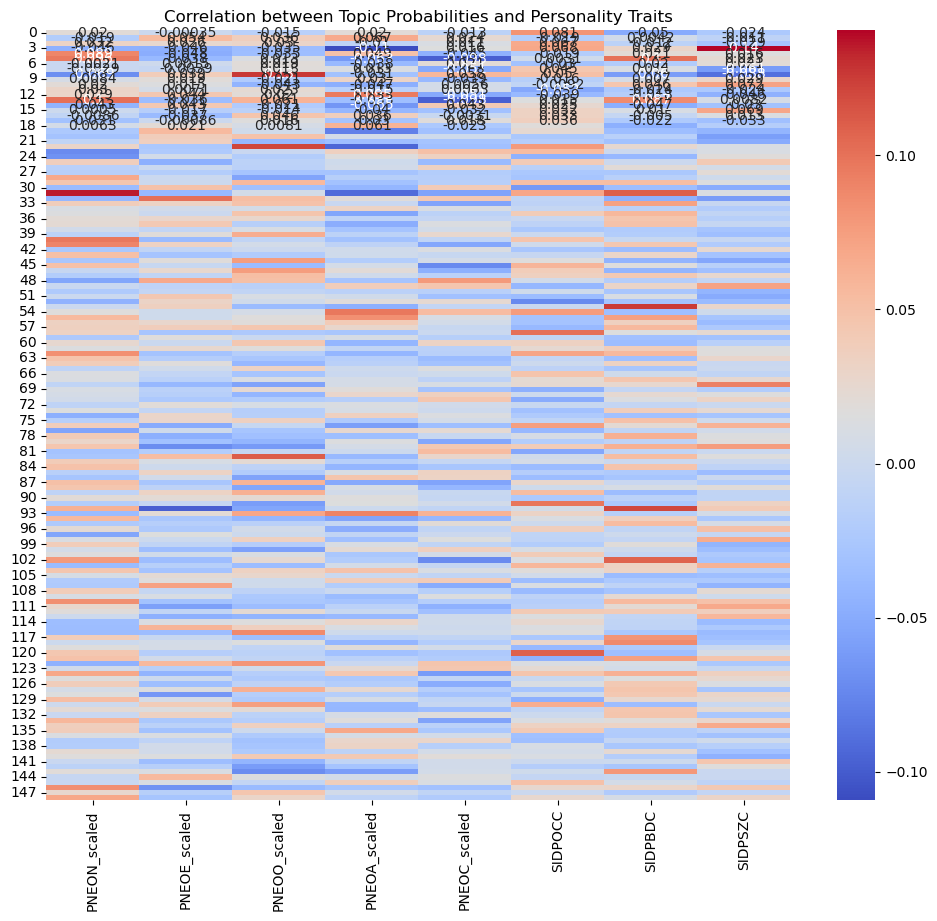

     PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled  \
0        0.020255     -0.000348     -0.015008      0.019893     -0.012631   
1       -0.019310      0.054267      0.036416      0.067196      0.024076   
2        0.032047      0.025842      0.030157     -0.010041      0.011160   
3       -0.045729     -0.046423     -0.035333     -0.109239      0.015612   
4        0.089014     -0.048353     -0.035035      0.048883     -0.045153   
5        0.095812     -0.038138      0.012535     -0.062890     -0.098329   
6       -0.002144      0.001537      0.018736     -0.038496      0.021469   
7       -0.002854     -0.003863      0.017989      0.012552     -0.051347   
8       -0.069477      0.038809      0.126578     -0.030672      0.057881   
9        0.008429      0.019294     -0.020761      0.030474     -0.038946   
10       0.020006      0.014513     -0.043487     -0.046810      0.005642   
11       0.029590      0.007090      0.022627     -0.014952      0.006252   

In [192]:
# Compute the correlation matrix
corr_matrix = cleaned_df[topic_columns + personality_columns].corr()

# Extract correlations between topic probabilities and personality traits
corr_topics_personality = corr_matrix.loc[topic_columns, personality_columns]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_topics_personality, annot=True, cmap='coolwarm')
plt.title('Correlation between Topic Probabilities and Personality Traits')
plt.show()

# Print correlation matrix for reference
print(corr_topics_personality)

In [207]:
corr_matrix

0         1         2         3         4         5  \
0             1.000000  0.077126  0.067702  0.048510  0.019254  0.004015   
1             0.077126  1.000000  0.016918 -0.061538 -0.057968  0.008786   
2             0.067702  0.016918  1.000000  0.036301  0.012703  0.041683   
3             0.048510 -0.061538  0.036301  1.000000 -0.023530  0.004945   
4             0.019254 -0.057968  0.012703 -0.023530  1.000000 -0.010338   
5             0.004015  0.008786  0.041683  0.004945 -0.010338  1.000000   
6             0.030057  0.028298 -0.011825  0.049862 -0.055095 -0.051985   
7             0.067508  0.097550  0.043395  0.033803 -0.027183  0.055538   
8             0.060019  0.030307  0.055752  0.057584 -0.049765 -0.012035   
9            -0.031308  0.011699 -0.091525 -0.009444  0.082633 -0.014076   
10            0.070388  0.025941 -0.048476  0.000067  0.047565  0.045569   
11           -0.020739  0.040107  0.046564 -0.015821  0.085988  0.029020   
12            0.027348  0.057315 -0.006443 -0.027075  0.039582 -0.067751   
13           -0.007975  0.015849 -0.005640  0.020078  0.041891  0.057375   
14            0.028398  0.010301 -0.007125  0.060444 -0.068194  0.085878   
15            0.043834  0.028315 -0.053736  0.022090 -0.046070  0.014816   
16            0.036375  0.053682  0.005812 -0.024568 -0.024214 -0.032446   
17            0.021537 -0.025570  0.069461 -0.039186  0.058018  0.018771   
18            0.031054 -0.041106 -0.031827 -0.031363  0.060193 -0.005528   
19            0.102195 -0.037630  0.064167  0.018140 -0.044116 -0.010371   
20           -0.005639  0.033977  0.007794 -0.017161 -0.006441  0.033022   
21            0.057809 -0.007570 -0.039680  0.055978 -0.055011 -0.004629   
22           -0.046255  0.002305  0.088876  0.005308 -0.014205  0.057729   
23            0.024428 -0.018038  0.096929  0.004780 -0.024003 -0.000909   
24            0.038490 -0.021234 -0.025707 -0.038075  0.014622  0.047645   
25            0.043302  0.024429 -0.010090 -0.001798  0.015303  0.011355   
26           -0.006307  0.020746 -0.000330  0.031594  0.041614 -0.003187   
27           -0.036441 -0.003057  0.032054  0.022118 -0.003340 -0.004017   
28            0.029305  0.014343  0.023669  0.061235  0.070756  0.018722   
29            0.034435  0.070789 -0.018193  0.075522  0.006867  0.016867   
30            0.028113  0.046137  0.017772  0.001185  0.013543  0.041940   
31           -0.008520  0.047975 -0.048409 -0.021775  0.002642  0.058522   
32           -0.049553  0.005128  0.010512 -0.044129 -0.022495  0.001099   
33           -0.025138  0.037266 -0.060709 -0.028190 -0.004377  0.040005   
34            0.014919 -0.020544  0.075808  0.005429  0.000418  0.054335   
35            0.000537  0.022358 -0.024689  0.035007 -0.042936  0.028222   
36            0.041242  0.025406 -0.026762 -0.030643 -0.015484  0.078365   
37           -0.003440  0.056187  0.047315  0.010507  0.007541 -0.016038   
38            0.070538  0.058714  0.077394  0.012316 -0.014555  0.034756   
39            0.013157  0.013803  0.041807 -0.031571 -0.000003 -0.015670   
40            0.024411 -0.028923  0.009885 -0.042162 -0.037003  0.045856   
41            0.029186 -0.002632  0.077639  0.060820 -0.011536  0.016840   
42            0.015730  0.047300 -0.014234 -0.027589  0.000092 -0.022864   
43            0.017319  0.044152  0.087689  0.046633 -0.032447  0.058286   
44           -0.009678 -0.032629  0.026446 -0.044544 -0.022606 -0.022441   
45            0.042422  0.024850  0.063421  0.000217  0.003073  0.080484   
46            0.001245 -0.020896 -0.039656 -0.013517  0.059488  0.054344   
47            0.008292 -0.022272 -0.007341  0.001102 -0.028487 -0.049084   
48            0.015674 -0.012192  0.057971  0.042105 -0.032096 -0.036734   
49            0.035308  0.053524 -0.005565 -0.008706  0.070246  0.011984   
50            0.011699 -0.038038  0.008123  0.042463 -0.018632  0.016162   
51           -0.020517  0.015045 -0.030053 -0.043026  0.020704  0.027

In [245]:
from scipy import stats

df_corr = pd.DataFrame() # Correlation matrix
df_p = pd.DataFrame()  # Matrix of p-values
for x in cleaned_df_new[topic_columns + personality_columns].columns:
    for y in cleaned_df_new[topic_columns + personality_columns].columns:
        corr = stats.pearsonr(cleaned_df_new[x], cleaned_df_new[y])
        df_corr.loc[x,y] = corr[0]
        df_p.loc[x,y] = corr[1]

/var/folders/4n/sqksc27s00b9xhqnx1xr7qjwkq6yb5/T/ipykernel_60452/3925366924.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_corr.loc[x,y] = corr[0]
/var/folders/4n/sqksc27s00b9xhqnx1xr7qjwkq6yb5/T/ipykernel_60452/3925366924.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_p.loc[x,y] = corr[1]
/var/folders/4n/sqksc27s00b9xhqnx1xr7qjwkq6yb5/T/ipykernel_60452/3925366924.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [247]:
corr

PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled  \
0        0.020255     -0.000348     -0.015008      0.019893     -0.012631   
1       -0.019310      0.054267      0.036416      0.067196      0.024076   
2        0.032047      0.025842      0.030157     -0.010041      0.011160   
3       -0.045729     -0.046423     -0.035333     -0.109239      0.015612   
4        0.089014     -0.048353     -0.035035      0.048883     -0.045153   
5        0.095812     -0.038138      0.012535     -0.062890     -0.098329   
6       -0.002144      0.001537      0.018736     -0.038496      0.021469   
7       -0.002854     -0.003863      0.017989      0.012552     -0.051347   
8       -0.069477      0.038809      0.126578     -0.030672      0.057881   
9        0.008429      0.019294     -0.020761      0.030474     -0.038946   
10       0.020006      0.014513     -0.043487     -0.046810      0.005642   
11       0.029590      0.007090      0.022627     -0.014952      0.006252   
12       0.028928      0.043992      0.019571      0.095456     -0.050887   
13       0.101370     -0.036060      0.060886     -0.033350     -0.097923   
14      -0.043454      0.043404     -0.021147     -0.064934      0.042734   
15       0.000503     -0.016999     -0.013596     -0.040409     -0.031581   
16      -0.008567     -0.037352      0.046163      0.036204     -0.003120   
17      -0.030565     -0.000860      0.016490     -0.029915      0.018072   
18       0.006316      0.020728      0.008077      0.061241     -0.023400   
19      -0.024005      0.055202      0.003624     -0.078563     -0.031920   
20      -0.030027      0.037492      0.048249      0.006630      0.002795   
21      -0.008168      0.035608     -0.040711     -0.034822     -0.028485   
22       0.029587     -0.024703      0.121599     -0.094172     -0.032232   
23      -0.071810     -0.022230     -0.001982      0.034502      0.049934   
24      -0.068088      0.005308     -0.018852      0.016391      0.033887   
25       0.036355     -0.046323     -0.012613      0.002646     -0.037248   
26      -0.015557     -0.001007     -0.013383      0.004199      0.034067   
27      -0.015685     -0.019174     -0.029161     -0.028483     -0.018523   
28       0.067591     -0.001000     -0.055386     -0.016494     -0.016726   
29       0.045170     -0.000243      0.056224     -0.030599     -0.015733   
30      -0.036614      0.049119     -0.033073     -0.041216      0.040449   
31       0.135528     -0.038022      0.005078     -0.090819     -0.056473   
32      -0.040323      0.100543      0.052260      0.018561      0.043136   
33       0.037829      0.031629      0.048678     -0.002832     -0.054765   
34       0.011610      0.004298      0.006832      0.032073      0.011574   
35       0.013906     -0.000298      0.046024     -0.053850     -0.012320   
36       0.021102      0.027603      0.026400     -0.009732     -0.006596   
37       0.021600      0.042375     -0.015761     -0.047838      0.013016   
38       0.004285     -0.007633      0.010092     -0.028380      0.005395   
39      -0.012287      0.017815      0.065138     -0.011945      0.025465   
40       0.097083     -0.037708     -0.008391     -0.030405     -0.009208   
41       0.090747      0.033207      0.004991     -0.011500     -0.052674   
42      -0.024476     -0.007922     -0.000381      0.003755      0.013664   
43       0.050022     -0.028727     -0.020994      0.002015     -0.002960   
44      -0.026846      0.017930      0.075486     -0.018951      0.006084   
45       0.048899     -0.003576     -0.036904      0.006734     -0.072301   
46      -0.004143      0.025528      0.075308      0.020016     -0.045889   
47      -0.019463     -0.009699      0.052729      0.003624     -0.013237   
48      -0.054503      0.067679      0.050006     -0.028671      0.077634   
49      -0.002527     -0.010332     -0.013991      0.037782      0.045626   
50      -0.022150     -0.006293     -0.008002     -0.013076     -0.014862   
5

In [246]:
# Extract correlations between topic probabilities and personality traits
corr = df_corr.loc[topic_columns, personality_columns]
corr_p = df_p.loc[topic_columns, personality_columns]

In [212]:
corr_p.to_csv('corr_p.csv')
corr.to_csv('corr.csv')

In [206]:
df_p

0             1         2         3         4         5  \
0             0.000000  1.485659e-02  0.032558  0.125845  0.543692  0.899236   
1             0.014857  0.000000e+00  0.593638  0.052078  0.067310  0.781712   
2             0.032558  5.936380e-01  0.000000  0.252148  0.688714  0.188484   
3             0.125845  5.207842e-02  0.252148  0.000000  0.458002  0.876065   
4             0.543692  6.731043e-02  0.688714  0.458002  0.000000  0.744401   
5             0.899236  7.817122e-01  0.188484  0.876065  0.744401  0.000000   
6             0.343084  3.720822e-01  0.709208  0.115624  0.082075  0.100906   
7             0.033060  2.044614e-03  0.170956  0.286291  0.391220  0.079638   
8             0.058165  3.390864e-01  0.078486  0.069148  0.116331  0.704271   
9             0.323374  7.121650e-01  0.003824  0.765840  0.009045  0.657092   
10            0.026251  4.132424e-01  0.126107  0.998308  0.133397  0.150493   
11            0.513056  2.057587e-01  0.141772  0.617818  0.006593  0.360005   
12            0.388358  7.045910e-02  0.839000  0.393116  0.211760  0.032433   
13            0.801425  6.171917e-01  0.858823  0.526578  0.186285  0.070162   
14            0.370401  7.452955e-01  0.822222  0.056405  0.031313  0.006663   
15            0.166665  3.717985e-01  0.089920  0.485983  0.146051  0.640322   
16            0.251183  9.024518e-02  0.854582  0.438398  0.445028  0.306088   
17            0.496963  4.199465e-01  0.028297  0.216367  0.067075  0.553836   
18            0.327309  1.946769e-01  0.315410  0.322516  0.057439  0.861617   
19            0.001232  2.351800e-01  0.042803  0.567242  0.163953  0.743627   
20            0.858853  2.838137e-01  0.805845  0.588347  0.839035  0.297567   
21            0.068064  8.113152e-01  0.210627  0.077280  0.082542  0.883939   
22            0.144438  9.420610e-01  0.004980  0.867049  0.654169  0.068447   
23            0.441015  5.694290e-01  0.002185  0.880178  0.449018  0.977135   
24            0.224644  5.030525e-01  0.417461  0.229687  0.644701  0.132747   
25            0.171873  4.410066e-01  0.750332  0.954793  0.629375  0.720266   
26            0.842347  5.129040e-01  0.991690  0.318963  0.189220  0.919942   
27            0.250320  9.231961e-01  0.311967  0.485436  0.916116  0.899201   
28            0.355297  6.510319e-01  0.455348  0.053250  0.025473  0.554887   
29            0.277362  2.540468e-02  0.566119  0.017076  0.828552  0.594758   
30            0.375221  1.454652e-01  0.575133  0.970192  0.669307  0.185772   
31            0.788177  1.300742e-01  0.126638  0.492224  0.933595  0.064729   
32            0.117896  8.715318e-01  0.740264  0.163829  0.478018  0.972343   
33            0.427851  2.397454e-01  0.055333  0.373905  0.890218  0.206915   
34            0.637987  5.170223e-01  0.016661  0.864054  0.989494  0.086392   
35            0.986480  4.807152e-01  0.436151  0.269463  0.175529  0.373371   
36            0.193204  4.229432e-01  0.398603  0.333756  0.625310  0.013320   
37            0.913615  7.618166e-02  0.135455  0.740368  0.812016  0.612988   
38            0.025932  6.385482e-02  0.014512  0.697710  0.646207  0.272905   
39            0.678200  6.633335e-01  0.187171  0.319319  0.999937  0.621173   
40            0.441343  3.616094e-01  0.755230  0.183456  0.243086  0.147939   
41            0.357267  9.338382e-01  0.014203  0.054886  0.716010  0.595358   
42            0.619829  1.355791e-01  0.653512  0.384186  0.997695  0.470836   
43            0.584923  1.636063e-01  0.005594  0.141182  0.306064  0.065819   
44            0.760209  3.033610e-01  0.404210  0.159894  0.475856  0.479089   
45            0.180759  4.331605e-01  0.045279  0.994539  0.922810  0.011014   
46            0.968693  5.098777e-01  0.210911  0.669905  0.060427  0.086340   
47            0.793700  4.824071e-01  0.816932  0.972275  0.368900  0.121424   
48            0.621084  7.006212e-01  0.067295  0.184045  0.311335  0.246533   
49            0.26535

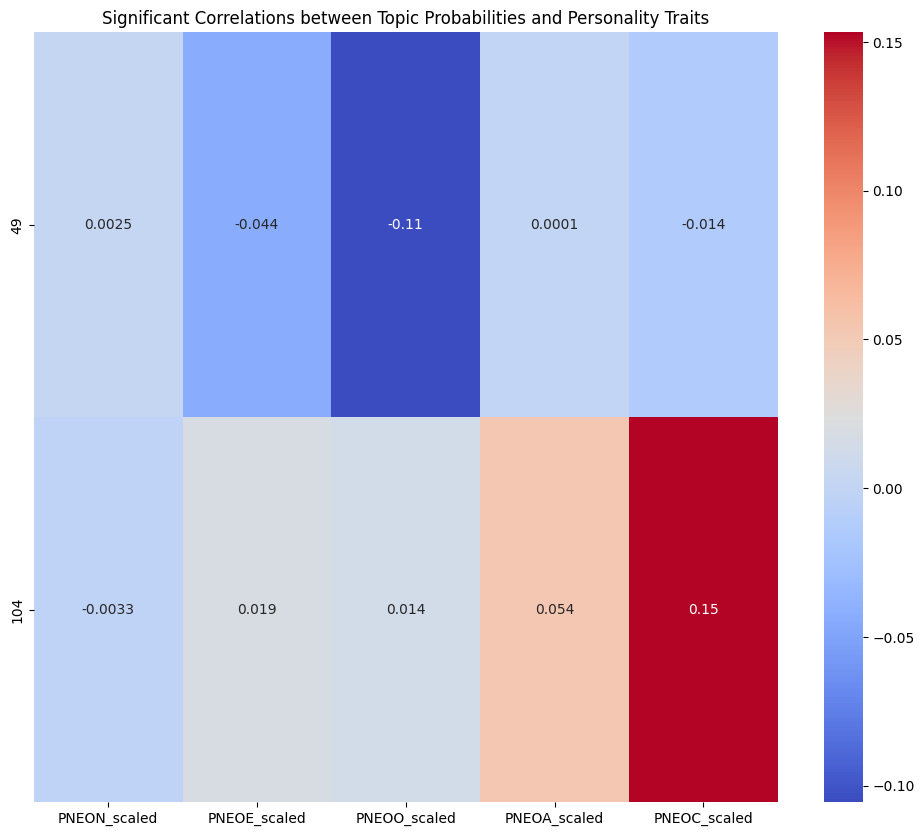

     PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled
49       0.002456     -0.043675     -0.105579      0.000100     -0.014210
104     -0.003285      0.018711      0.013654      0.053634      0.153335
       PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled
count    174.000000    174.000000    174.000000    174.000000    174.000000
mean      -0.001395      0.002032      0.001777      0.001140      0.001014
std        0.031466      0.034420      0.034212      0.033124      0.033380
min       -0.068850     -0.094518     -0.105579     -0.097026     -0.075399
25%       -0.025388     -0.020592     -0.020917     -0.021082     -0.022235
50%       -0.003122      0.003099      0.001539      0.001489     -0.001182
75%        0.023585      0.027337      0.022827      0.021319      0.020572
max        0.076937      0.084762      0.095554      0.072364      0.153335
Top N correlations:
 PNEOC_scaled  104    0.153335
PNEOO_scaled  49     0.105579
PNEOA_scaled 

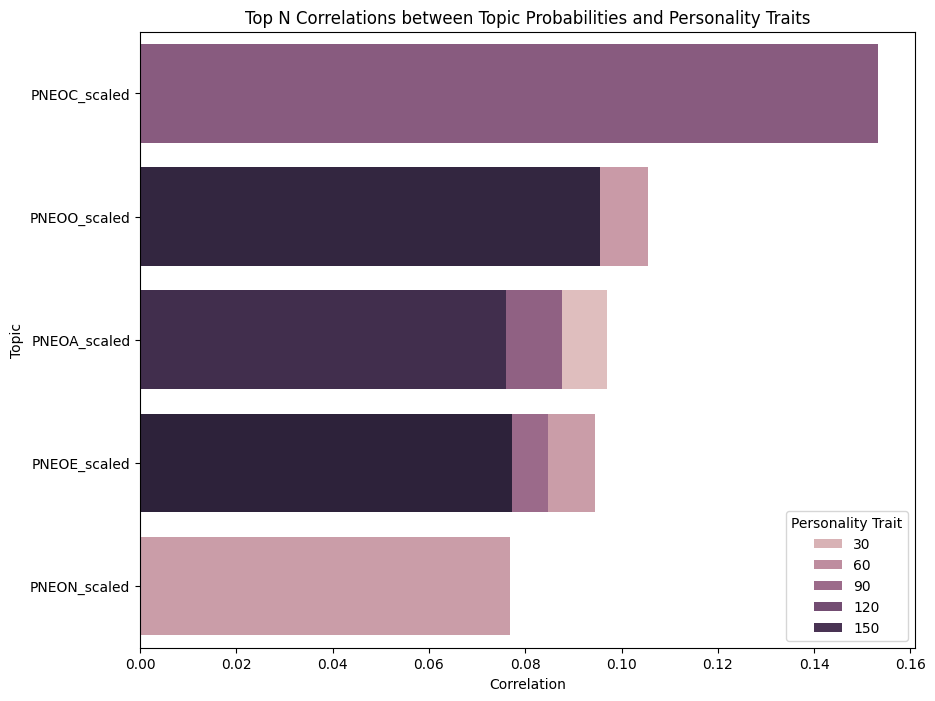

Summary statistics for the correlation matrix:
        PNEON_scaled  PNEOE_scaled  PNEOO_scaled  PNEOA_scaled  PNEOC_scaled
count    174.000000    174.000000    174.000000    174.000000    174.000000
mean      -0.001395      0.002032      0.001777      0.001140      0.001014
std        0.031466      0.034420      0.034212      0.033124      0.033380
min       -0.068850     -0.094518     -0.105579     -0.097026     -0.075399
25%       -0.025388     -0.020592     -0.020917     -0.021082     -0.022235
50%       -0.003122      0.003099      0.001539      0.001489     -0.001182
75%        0.023585      0.027337      0.022827      0.021319      0.020572
max        0.076937      0.084762      0.095554      0.072364      0.153335


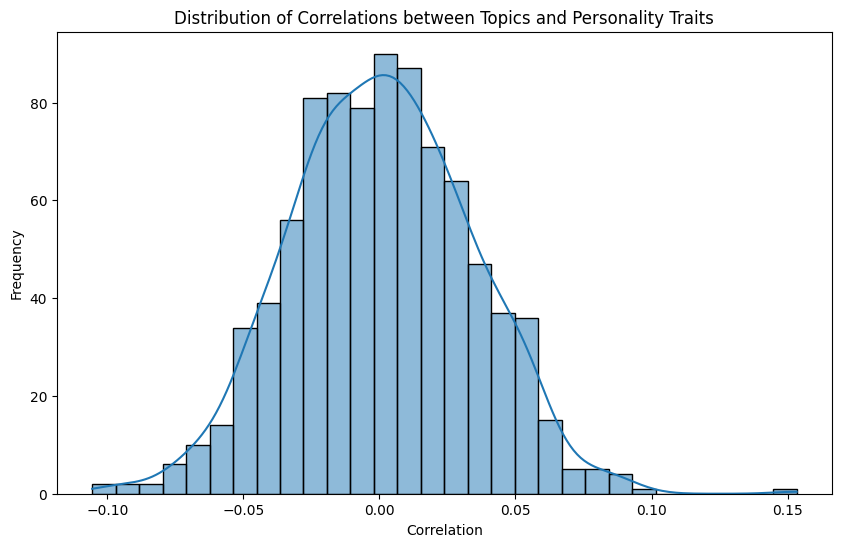

In [ ]:
# Filter significant correlations:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Filter correlations with an absolute value greater than 0.3
significant_corr = corr_topics_personality[(corr_topics_personality.abs() > 0.1).any(axis=1)]

# Check if significant_corr is empty
if not significant_corr.empty:
    # Plot the heatmap of significant correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(significant_corr, annot=True, cmap='coolwarm')
    plt.title('Significant Correlations between Topic Probabilities and Personality Traits')
    plt.show()

    # Print significant correlations
    print(significant_corr)
else:
    print("No significant correlations found with the given threshold.")

# Compute summary statistics for each personality score
summary_stats = corr_topics_personality.describe()
print(summary_stats)


# Identify top N correlations:

# Unstack the correlation matrix and sort by absolute value
corr_unstacked = corr_topics_personality.unstack().abs().sort_values(ascending=False)

# Identify top N correlations (excluding self-correlations)
top_n = 20
top_corr = corr_unstacked[corr_unstacked != 1].head(top_n)
print("Top N correlations:\n", top_corr)

# Reshape to DataFrame for better readability
top_corr_df = pd.DataFrame(top_corr).reset_index()
top_corr_df.columns = ['Topic', 'Personality Trait', 'Correlation']

# Plot top N correlations
plt.figure(figsize=(10, 8))
sns.barplot(data=top_corr_df, x='Correlation', y='Topic', hue='Personality Trait', dodge=False)
plt.title('Top N Correlations between Topic Probabilities and Personality Traits')
plt.show()


# Descriptives statistics and visualization:

# Compute summary statistics for each personality score
summary_stats = corr_topics_personality.describe()
print("Summary statistics for the correlation matrix:\n", summary_stats)

# Plot distribution of correlations
plt.figure(figsize=(10, 6))
sns.histplot(corr_topics_personality.values.flatten(), bins=30, kde=True)
plt.title('Distribution of Correlations between Topics and Personality Traits')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()




Top 10 topics correlated with PNEON_scaled:
   Personality Trait  Topic  Correlation   P-value
30      PNEON_scaled     47     0.076937  0.015206
31      PNEON_scaled     41     0.074423  0.018880
32      PNEON_scaled     33     0.063437  0.045443
33      PNEON_scaled     67     0.059923  0.058822
34      PNEON_scaled    155     0.059387  0.061128
35      PNEON_scaled     77     0.055326  0.081103
36      PNEON_scaled      4     0.054175  0.087638
37      PNEON_scaled    108     0.051580  0.103935
38      PNEON_scaled     82     0.049313  0.120062
39      PNEON_scaled     87     0.048662  0.125044

Top 10 topics correlated with PNEOE_scaled:
   Personality Trait  Topic  Correlation   P-value
20      PNEOE_scaled     91     0.084762  0.007470
21      PNEOE_scaled    170     0.077170  0.014900
22      PNEOE_scaled    120     0.069381  0.028639
23      PNEOE_scaled     45     0.064501  0.041934
24      PNEOE_scaled     71     0.061248  0.053439
25      PNEOE_scaled     30     0.060583  0

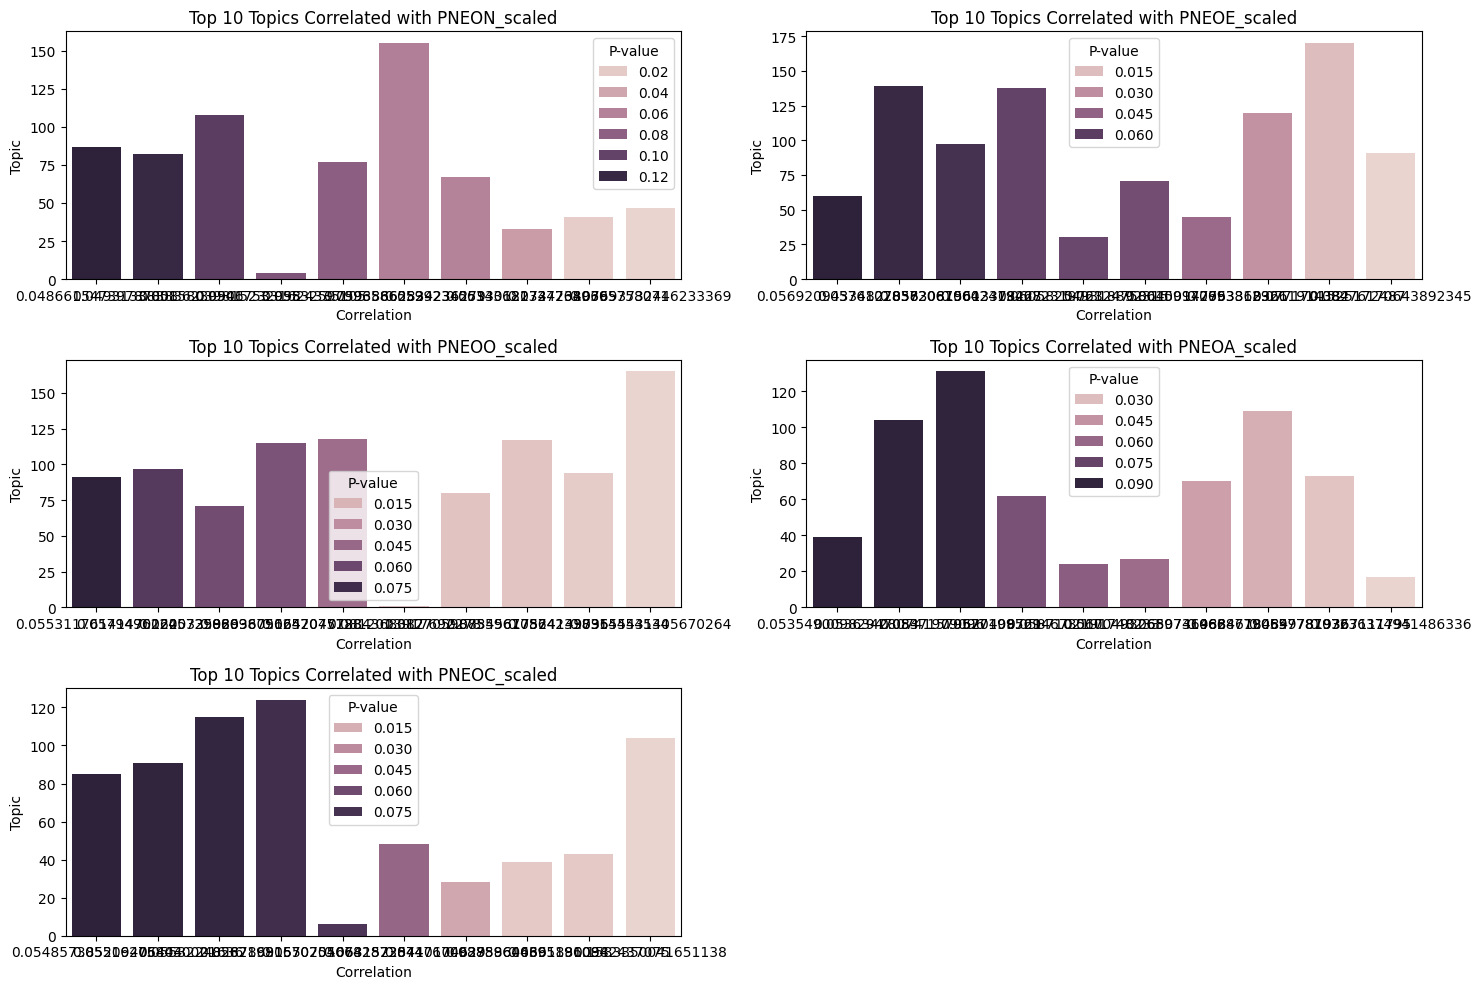

In [ ]:
# 1) Calculate correlations and p-values using scipy
# 2) Identify Top Correlations
# 3) Compile and Display Results

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Assuming merged_df is already prepared and cleaned
# Ensure non-numeric values are converted to NaN and dropped
merged_df = merged_df.apply(pd.to_numeric, errors='coerce').dropna()

# Select topic probabilities and personality scores for correlation analysis
topic_columns = [col for col in merged_df.columns if isinstance(col, int)]
personality_columns = ['PNEON_scaled', 'PNEOE_scaled', 'PNEOO_scaled', 'PNEOA_scaled', 'PNEOC_scaled']

# Calculate correlations and p-values
results = []
for personality in personality_columns:
    for topic in topic_columns:
        corr, p_value = pearsonr(merged_df[topic], merged_df[personality])
        results.append((personality, topic, corr, p_value))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Personality Trait', 'Topic', 'Correlation', 'P-value'])

# Identify top 10 correlations for each personality trait
top_correlations = results_df.groupby('Personality Trait').apply(lambda x: x.nlargest(10, 'Correlation')).reset_index(drop=True)

# Display the results
for trait in personality_columns:
    print(f"\nTop 10 topics correlated with {trait}:")
    print(top_correlations[top_correlations['Personality Trait'] == trait])

# Plot significant correlations
plt.figure(figsize=(15, 10))
for i, trait in enumerate(personality_columns):
    plt.subplot(3, 2, i+1)
    sns.barplot(data=top_correlations[top_correlations['Personality Trait'] == trait],
                x='Correlation', y='Topic', hue='P-value', dodge=False)
    plt.title(f'Top 10 Topics Correlated with {trait}')
plt.tight_layout()
plt.show()



# 6) Extracting Topics and Keywords

In [ ]:
topic_model.visualize_barchart(top_n_topics=1000)

In [ ]:
# Save the barchart visualizations:

# Generate the bar chart visualization
bar_chart = topic_model.visualize_barchart(top_n_topics=1000)

# Save the visualization to an HTML file
bar_chart.write_html('/content/drive/My Drive/topic_bar_chart.html')

In [ ]:
# Get top 10 keywords for each of the first 5 topics
for topic_num in range(50):  # Adjust range as needed to see more topics
    print(f"Topic {topic_num}:")
    print(topic_model.get_topic(topic_num))
    print("\n")


Topic 0:
[('vietnam', 0.03141191325846561), ('military', 0.026279743288599073), ('army', 0.018251048069406847), ('war', 0.015844641686206012), ('drafted', 0.013940440449539892), ('training', 0.012778174164591535), ('draft', 0.012632809912021724), ('navy', 0.011173714133665455), ('service', 0.010446173344439839), ('duty', 0.009744608725031467)]


Topic 1:
[('church', 0.034742043848552964), ('catholic', 0.014823746563552313), ('god', 0.012858911941361843), ('seminary', 0.012534555311040604), ('bible', 0.01182228754145074), ('pastor', 0.011525655802498456), ('religious', 0.009882782144670992), ('ministry', 0.008459939178526124), ('religion', 0.008112281856446153), ('lord', 0.00810650671126625)]


Topic 2:
[('teaching', 0.031775038233967025), ('teacher', 0.018740340021529762), ('teachers', 0.017415929584260376), ('taught', 0.016182011614141893), ('teach', 0.013229488791106536), ('principal', 0.012547736164312649), ('classroom', 0.011424662412925), ('grade', 0.011152518878571925), ('school'

# Word Cloud Generation

In [ ]:
# Visualize top words in topics with a bar chart
topic_model.visualize_barchart(top_n_topics=5)

# Or generate word clouds for the first 5 topics
for topic_num in range(5):  # Adjust as needed
    topic_model.visualize_wordcloud(topic_num)


# Topic Correlations and Word Clouds for Each Personality Trait

In [ ]:
# Assuming you've identified a topic number associated with a trait
topic_number = 1  # example topic number
topic_model.visualize_wordcloud(topic_number)


# Save topic probabilities

In [ ]:
# Assuming `df['preprocessed_text']` is our preprocessed data

topics, probabilities = topic_model.transform(df['preprocessed_text'])


# Save the Data

In [ ]:
# Save the DataFrame to a CSV file (or any other format)
# ... Can then use as input for our subsequent machine learning model.

probabilities_df.to_csv('topic_probabilities.csv', index=False)


In [1]:
import pandas as pd
import numpy as np
import nltk
import contractions
import re

In [2]:
emb=pd.read_csv("topic_embeddings_150topics.csv",header=0)

In [3]:
emb.head()

0         1         2         3         4         5         6  \
0 -0.006305  0.010605  0.021326  0.019569  0.025413 -0.011089  0.030427   
1 -0.010093 -0.002707  0.032417 -0.004628  0.012497  0.045335 -0.013467   
2  0.018575  0.023014  0.016954  0.015586  0.030043 -0.003548  0.010768   
3  0.002393  0.035165  0.020885  0.015534  0.010980  0.021385  0.043627   
4 -0.017348  0.008769  0.021845  0.016925  0.041452  0.013157  0.025274   

          7         8         9  ...       374       375       376       377  \
0 -0.007738  0.018502 -0.025054  ...  0.027611 -0.016832 -0.001429  0.010657   
1  0.000267  0.009588 -0.015401  ...  0.005639  0.022711  0.006116  0.013033   
2 -0.022673  0.050799 -0.038172  ...  0.024526  0.005970  0.009569  0.017983   
3  0.066146  0.051029 -0.035491  ...  0.010788  0.030196 -0.016384  0.047484   
4 -0.016598 -0.039856  0.000882  ...  0.015725  0.020856  0.006676  0.003055   

        378       379       380       381       382       383  
0 -0.041766 -0.005431  0.025810 -0.006314 -0.044890 -0.004938  
1 -0.071733 -0.022514  0.050213 -0.023455 -0.072552 -0.013298  
2 -0.031786 -0.047111  0.017473 -0.019351 -0.059156 -0.031377  
3 -0.088397 -0.034594  0.096375 -0.013811 -0.117425  0.013219  
4 -0.042959  0.000495  0.002330 -0.018588 -0.086845  0.004637  

[5 rows x 384 columns]

In [4]:
emb.shape

(150, 384)

In [662]:
prob=pd.read_csv("150_merged_topic_personality_scores_max.csv",header=0)

In [663]:
prob.shape

(1124, 158)

In [7]:
emb_roberta.shape

NameError: name 'emb_roberta' is not defined

In [695]:
prob = prob.apply(pd.to_numeric, errors='coerce')
#prob = prob[prob.isna().any(axis=1)]

In [696]:
prob.dropna(inplace=True)

In [697]:
prob.shape

(1054, 164)

In [667]:
new_score=pd.read_csv('PD_scores_top3_new_new.csv',header=0)

In [668]:
new_score.head()

PARTID     PNEOSZ_SCALED     PNEOBD_SCALED     PNEOOC_SCALED  \
0    1001               107               107               251   
1    1002                81               123  197.902912621359   
2    1003  105.290322580645  127.774647887324  201.882352941176   
3    1004               115               146               217   
4    1005               125               118               227   

             MAPPSZ            MAPPBD MAPPOC  
0  .571428571428571  .111111111111111   1.75  
1  .428571428571429                 0    .75  
2                 1                 0     .5  
3  .714285714285714  .444444444444444    .75  
4  .285714285714286                 0      0

In [694]:
new_score.shape

(1630, 7)

In [674]:
prob=pd.merge(prob,new_score,on='PARTID',how='left')
prob.shape

(1063, 164)

In [675]:
prob.head()

0         1         2         3         4         5         6  \
0  0.361508  0.082673  0.013152  0.005520  1.000000  0.006924  0.216859   
1  0.288058  0.017912  0.010925  0.006471  0.233267  0.207520  0.046636   
2  0.248013  0.012774  0.012616  0.007884  0.013020  0.007991  1.000000   
3  0.760558  0.051096  0.148577  0.005867  0.056968  0.025481  0.033404   
4  1.000000  1.000000  0.013041  0.020204  0.038758  0.016136  0.043495   

          7         8         9  ...  PNEOC_scaled  SIDPOCC  SIDPBDC  SIDPSZC  \
0  0.021029  0.016931  0.008138  ...         125.0        2        0        0   
1  0.052662  0.029315  0.008729  ...         117.0        0        2        1   
2  0.618590  0.118891  0.016452  ...         100.0        2        0        0   
3  0.048217  0.040671  0.153831  ...         129.6        2        1        0   
4  0.134860  0.063245  0.028207  ...         110.0        0        0        0   

      PNEOSZ_SCALED     PNEOBD_SCALED     PNEOOC_SCALED            MAPPSZ  \
0                81               123  197.902912621359  .428571428571429   
1               115               146               217  .714285714285714   
2  89.3968253968254               134  163.572815533981  .428571428571429   
3  110.730158730159  129.802816901408               208  1.42857142857143   
4               100               121               200  .285714285714286   

             MAPPBD  MAPPOC  
0                 0     .75  
1  .444444444444444     .75  
2  .111111111111111      .5  
3  .111111111111111    .625  
4                 0      .5  

[5 rows x 164 columns]

In [698]:
emb_roberta=pd.read_csv('emb_N.csv',header=0)
emb_roberta=pd.merge(emb_roberta,prob['PARTID'],on='PARTID',how='inner')
emb_roberta.shape

(1054, 1025)

In [699]:
prob=prob[prob['PARTID'].isin(emb_roberta['PARTID'])]
emb_roberta=emb_roberta[emb_roberta['PARTID'].isin(prob['PARTID'])]
prob=prob.sort_values(by='PARTID')
emb_roberta=emb_roberta.sort_values(by='PARTID')

In [700]:
liwc=pd.read_csv('LIWC_9.1.24_reduced.csv',header=0)
liwc=pd.merge(liwc,prob['PARTID'],on='PARTID',how='inner')
liwc=liwc.sort_values(by='PARTID')
liwc.shape

(1054, 118)

In [701]:
liwc = liwc.apply(pd.to_numeric, errors='coerce')

In [702]:
liwc=liwc.dropna()
liwc.shape

(1054, 118)

In [16]:
def average_top_n_topic_embeddings(doc_idx, top_n):
    # Get the topic probabilities for the document
    topic_probs = prob.iloc[doc_idx,0:149]
    #print("topic_probs",topic_probs)
    # Sort the topics by probability, and select the top N topics
    top_n_topic_indices = np.argsort(topic_probs)[-top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    # Get the embeddings for the top N topics
    top_n_embeddings = emb.loc[top_n_topic_indices]
    #print(top_n_embeddings)
    # Calculate the average embedding
    avg_embedding = np.mean(top_n_embeddings, axis=0)
    #print(avg_embedding)
    return avg_embedding

In [25]:
def tl_average_top_n_topic_embeddings(doc_idx, top_n):
    # Get the topic probabilities for the document
    topic_probs = prob.iloc[doc_idx,0:149]
    #print("topic_probs",topic_probs)
    # Sort the topics by probability, and select the top N topics
    top_n_topic_indices = np.argsort(topic_probs)[-top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    # Get the embeddings for the top N topics
    top_n_embeddings = emb.loc[top_n_topic_indices]
    top_n_embeddings=np.asarray(top_n_embeddings)
    low_n_topic_indices = np.argsort(topic_probs)[top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    # Get the embeddings for the top N topics
    low_n_embeddings = emb.loc[low_n_topic_indices]
    low_n_embeddings=np.asarray(low_n_embeddings)
    #print(top_n_embeddings)
    # Calculate the average embedding
    top_avg_embedding = np.mean(top_n_embeddings, axis=0)
    low_avg_embedding = np.mean(low_n_embeddings, axis=0)
    concatenated_embedding = np.concatenate([top_avg_embedding,low_avg_embedding])
    
    #print(avg_embedding)
    return concatenated_embedding

In [23]:
def weight_average_top_n_topic_embeddings(doc_idx, top_n):
    # Get the topic probabilities for the document
    topic_probs = prob.iloc[doc_idx,0:149]
    #print("topic_probs",(topic_probs))
    #print("topic_probs",np.argsort(topic_probs))
    # Sort the topics by probability, and select the top N topics
    top_n_topic_indices = np.argsort(topic_probs)[-top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    top_n_topic_indices=top_n_topic_indices.tolist()
    probabilities = topic_probs[top_n_topic_indices]
    #print("probabilities",probabilities)
    normalized_probs = probabilities / np.sum(probabilities)
    print("normalized_probs",normalized_probs)
    # Get the embeddings for the top N topics
    top_n_embeddings = emb.loc[top_n_topic_indices]
    #print("top_n_embeddings",top_n_embeddings.shape)
    # Compute the weighted average of embeddings
    weighted_embedding = np.dot(normalized_probs, top_n_embeddings)
    #print("weighted_embedding",weighted_embedding)
    #print("weighted_embedding",weighted_embedding.shape)
    # Calculate the average embedding
    avg_embedding = weighted_embedding/top_n
    #print(avg_embedding)
    return avg_embedding

In [18]:
def concat_average_top_n_topic_embeddings(doc_idx, top_n):
    # Get the topic probabilities for the document
    topic_probs = prob.iloc[doc_idx,0:149]
    #print("topic_probs",(topic_probs))
    #print("topic_probs",np.argsort(topic_probs))
    # Sort the topics by probability, and select the top N topics
    top_n_topic_indices = np.argsort(topic_probs)[-top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    top_n_topic_indices=top_n_topic_indices.tolist()
    
    # Get the embeddings for the top N topics
    top_n_embeddings = emb.loc[top_n_topic_indices]
    top_n_embeddings=np.asarray(top_n_embeddings)
   # print("top_n_embeddings",top_n_embeddings)
    concatenated_embedding = np.concatenate(top_n_embeddings)
    #print("concatenated_embedding",concatenated_embedding)
    #print("concatenated_embedding",concatenated_embedding.shape)
    
    return concatenated_embedding

In [19]:
def max_average_top_n_topic_embeddings(doc_idx, top_n):
    # Get the topic probabilities for the document
    topic_probs = prob.iloc[doc_idx,0:149]
    #print("topic_probs",(topic_probs))
    #print("topic_probs",np.argsort(topic_probs))
    # Sort the topics by probability, and select the top N topics
    top_n_topic_indices = np.argsort(topic_probs)[-top_n:]
    #print("top_n_topic_indices",top_n_topic_indices.tolist())
    top_n_topic_indices=top_n_topic_indices.tolist()
    
    # Get the embeddings for the top N topics
    top_n_embeddings = emb.loc[top_n_topic_indices]
    top_n_embeddings=np.asarray(top_n_embeddings)
   # print("top_n_embeddings",top_n_embeddings)
    max_embedding = np.max(top_n_embeddings,axis=0)
    #print("concatenated_embedding",concatenated_embedding)
    #print("concatenated_embedding",concatenated_embedding.shape)
    
    return max_embedding

In [20]:
max_pooled_embedding = np.max(embeddings, axis=0)

NameError: name 'embeddings' is not defined

In [462]:
embeddings = np.array([
    [0.2, 0.3, 0.1],  # Embedding for topic 1
    [0.4, 0.1, 0.5],  # Embedding for topic 2
    [0.3, 0.6, 0.2],  # Embedding for topic 3
    [0.5, 0.4, 0.7],  # Embedding for topic 4
    [0.6, 0.2, 0.3]   # Embedding for topic 5
])

test=np.array(
    [1,2,3,1,2]   # Embedding for topic 5
)

In [463]:
concatenated_embedding = np.max(embeddings,axis=0)
concatenated_embedding

array([0.6, 0.6, 0.7])

In [38]:
avg=np.dot(test, embeddings)
avg/5

array([0.72, 0.62, 0.6 ])

In [161]:
from sklearn.preprocessing import StandardScaler
scaler_train=StandardScaler()
y_train_tensor_new = scaler_train.fit_transform(y_train_tensor.numpy().reshape(-1, 1))
y_train_tensor_new = torch.from_numpy(y_train_tensor_new)

scaler_testn=StandardScaler()
y_test_tensor_new = scaler_testn.fit_transform(y_test_tensor.numpy().reshape(-1, 1))
y_test_tensor_new = torch.from_numpy(y_test_tensor_new)

In [703]:
all_embs=[]
for i in range(prob.shape[0]):
    avg_embedding = tl_average_top_n_topic_embeddings(i, top_n=70)
    all_embs.append(avg_embedding)
#print(len(all_embs))

In [704]:
all_embs=np.asarray(all_embs)

In [705]:
all_embs.shape

(1054, 768)

In [706]:
all_embs=np.hstack((all_embs,np.asarray(emb_roberta.iloc[:,0:1024])))
all_embs.shape

(1054, 1792)

In [707]:
temp=np.asarray(liwc.iloc[:,1:])
temp.shape

(1054, 117)

In [708]:
all_embs=np.hstack((all_embs,np.asarray(liwc.iloc[:,1:])))
all_embs.shape

(1054, 1909)

In [709]:
all_embs=np.asarray(all_embs)

In [710]:
df = pd.DataFrame.from_records(all_embs)

In [711]:
df.head()

0         1         2         3         4         5         6     \
0 -0.010430  0.010551  0.014864  0.006396  0.018188 -0.007972  0.029666   
1 -0.009803  0.010139  0.016219  0.013816  0.022894 -0.007952  0.029116   
2 -0.004228  0.010085  0.015723  0.010817  0.018152 -0.011834  0.032043   
3 -0.007624  0.010134  0.012129  0.011254  0.020081 -0.011341  0.036284   
4 -0.008659  0.013264  0.014088  0.011835  0.018197 -0.008494  0.030865   

       7         8         9     ...  1899  1900  1901   1902   1903  1904  \
0  0.001305  0.009423 -0.016314  ...  1.56  0.67  0.00  31.92  17.63  6.70   
1 -0.000730  0.011225 -0.016393  ...  0.29  0.02  0.00  23.38  12.11  5.60   
2  0.004352  0.008440 -0.014543  ...  0.18  0.11  0.00  21.60   9.32  7.59   
3  0.001328  0.011315 -0.017406  ...  0.52  0.19  0.07  25.38  10.37  8.84   
4  0.004684  0.015323 -0.018265  ...  0.25  0.04  0.00  18.32   7.56  8.20   

   1905  1906  1907  1908  
0  1.79   0.0  5.58  0.22  
1  0.26   0.0  4.26  1.14  
2  0.25   0.0  3.21  1.24  
3  0.49   0.0  3.82  1.86  
4  0.07   0.0  2.17  0.32  

[5 rows x 1909 columns]

In [712]:
df.to_csv('avg_emb.csv',index=0)

In [713]:
from sklearn.metrics import r2_score

In [714]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [718]:
prob

0         1         2         3         4         5         6  \
0     0.361508  0.082673  0.013152  0.005520  1.000000  0.006924  0.216859   
1     0.288058  0.017912  0.010925  0.006471  0.233267  0.207520  0.046636   
2     0.248013  0.012774  0.012616  0.007884  0.013020  0.007991  1.000000   
3     0.760558  0.051096  0.148577  0.005867  0.056968  0.025481  0.033404   
4     1.000000  1.000000  0.013041  0.020204  0.038758  0.016136  0.043495   
...        ...       ...       ...       ...       ...       ...       ...   
1058  0.283328  0.100526  0.013223  0.159028  0.005785  0.016438  0.133309   
1059  1.000000  0.011418  0.401521  0.008265  0.004180  0.010375  0.027781   
1060  0.252853  0.012010  0.014505  0.006005  1.000000  0.009143  0.108257   
1061  0.005164  0.074360  0.009334  0.006112  0.008724  0.011956  0.056958   
1062  1.000000  1.000000  0.014729  0.010259  0.010763  0.492600  0.075309   

             7         8         9  ...  PNEOC_scaled  SIDPOCC  SIDPBDC  \
0     0.021029  0.016931  0.008138  ...         125.0        2        0   
1     0.052662  0.029315  0.008729  ...         117.0        0        2   
2     0.618590  0.118891  0.016452  ...         100.0        2        0   
3     0.048217  0.040671  0.153831  ...         129.6        2        1   
4     0.134860  0.063245  0.028207  ...         110.0        0        0   
...        ...       ...       ...  ...           ...      ...      ...   
1058  0.059443  0.100611  1.000000  ...         103.0        2        0   
1059  0.288684  0.033734  0.009460  ...         120.0        1        0   
1060  0.051463  0.031648  1.000000  ...         119.0        0        0   
1061  0.067161  1.000000  0.032248  ...         109.0        0        0   
1062  0.231370  0.102225  0.008876  ...         133.0        1        0   

      SIDPSZC  PNEOSZ_SCALED  PNEOBD_SCALED  PNEOOC_SCALED    MAPPSZ  \
0           0      81.000000     123.000000     197.902913  0.428571   
1           1     115.000000     146.000000     217.000000  0.714286   
2           0      89.396825     134.000000     163.572816  0.428571   
3           0     110.730159     129.802817     208.000000  1.428571   
4           0     100.000000     121.000000     200.000000  0.285714   
...       ...            ...            ...            ...       ...   
1058        1     121.000000     129.000000     213.000000  2.142857   
1059        0      91.000000     136.000000     192.000000  0.714286   
1060        1     128.000000      86.000000     228.000000  0.857143   
1061        0     100.000000     118.000000     197.000000  1.000000   
1062        0      82.000000     110.535211     200.932039  1.285714   

        MAPPBD  MAPPOC  
0     0.000000   0.750  
1     0.444444   0.750  
2     0.111111   0.500  
3     0.111111   0.625  
4     0.000000   0.500  
...        ...     ...  
1058  0.555556   1.875  
1059  0.444444   0.750  
1060  0.000000   0.000  
1061  0.111111   0.500  
1062  0.333333   1.375  

[1054 rows x 164 columns]

In [1238]:
prob.iloc[0:800,155]

0      2
1      0
2      2
3      2
4      0
      ..
804    0
805    1
806    0
807    2
808    2
Name: SIDPOCC, Length: 800, dtype: int64

In [1733]:
X_train_tensor = torch.from_numpy(all_embs[0:800,0:768])#0:384
X_test_tensor = torch.from_numpy(all_embs[800:,0:768])#1408#384:1408
y_train_tensor = torch.from_numpy(np.asarray(prob.iloc[0:800,157]))
y_test_tensor = torch.from_numpy(np.asarray(prob.iloc[800:,157]))
#torch.from_numpy(np_array)

In [1734]:
X_train_tensor.shape

torch.Size([800, 768])

In [1735]:
X_test_tensor.shape

torch.Size([254, 768])

In [1736]:
y_train_tensor=y_train_tensor.unsqueeze(1)
y_train_tensor.shape

torch.Size([800, 1])

In [1737]:
y_test_tensor=y_test_tensor.unsqueeze(1)
y_test_tensor.shape

torch.Size([254, 1])

In [1755]:
# Define the Feed-Forward Neural Network
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input to Hidden Layer
        self.fc4 = nn.Linear(1024, 512)
        self.relu = nn.LeakyReLU() 
        self.drop=nn.Dropout(0.5)# Activation function
        self.fc2 = nn.Linear(256, 64) # Hidden Layer
        self.fc3 = nn.Linear(64, output_size) # Hidden to Output Layer

    def forward(self, x):
        x = x.to(torch.float32)
        #print(x.shape)
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc4(x)
        #print(x.dtype)
        #x = self.relu(x)
        #print(x.dtype)
        #x = self.fc2(x)
        #print(x.dtype)
        x = self.relu(x)
        x=self.drop(x)
        #print(x.dtype)
        x = self.fc3(x)
        #print(x.dtype)
        return x

In [1756]:
# Model parameters
input_size = X_train_tensor.shape[1]
hidden_size = 64  # Can tune this
output_size = 1   # Regression has one output (continuous value)

In [1757]:
# Initialize the model, loss function, and optimizer
model = FeedForwardNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [1675]:
# Training the model
epochs = 10
for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    outputs = outputs.to(torch.float32)
    #print(outputs.shape)
    y_train_tensor = y_train_tensor.to(torch.float32)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update weights

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [1676]:
# Evaluating the model on the test set
#test_data['PNEON_scaled_new'] = scaler.fit_transform(test_data['PNEON_scaled'].to_numpy().reshape(-1, 1))
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


    # Convert predictions and actual values to numpy arrays for R^2 calculation
    y_test_numpy = y_test_tensor.numpy()
    predictions_numpy = predictions.numpy()

    # Calculate R^2 score
    r2 = r2_score(y_test_numpy[:,0],predictions_numpy[:,0])
    print(f'R^2 Score: {r2:.4f}')

Test Loss: 0.8938
R^2 Score: -0.1002


In [1758]:
# Training the model
epochs = 5000
maxr2=0
for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(X_train_tensor)
    outputs = outputs.to(torch.float32)
    #print(outputs.shape)
    y_train_tensor = y_train_tensor.to(torch.float32)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()        # Backpropagation
    optimizer.step()       # Update weights

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


    # Evaluating the model on the test set
    #test_data['PNEON_scaled_new'] = scaler.fit_transform(test_data['PNEON_scaled'].to_numpy().reshape(-1, 1))
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        test_loss = criterion(predictions, y_test_tensor)
        #print(f'Test Loss: {test_loss.item():.4f}')
    
    
        # Convert predictions and actual values to numpy arrays for R^2 calculation
        y_test_numpy = y_test_tensor.numpy()
        predictions_numpy = predictions.numpy()
    
        # Calculate R^2 score
        r2 = r2_score(y_test_numpy[:,0],predictions_numpy[:,0])
        print(f'R^2 Score: {r2:.4f}')
        if r2>maxr2:
            maxr2=r2
            torch.save(model, 'model_szc_sidp2.pth')
            print("==========================MODEL SAVED==========================")

R^2 Score: -0.0064
R^2 Score: -0.0022
R^2 Score: -0.0003
R^2 Score: -0.0003
R^2 Score: -0.0008
R^2 Score: -0.0004
R^2 Score: -0.0003
R^2 Score: -0.0004
R^2 Score: -0.0007
R^2 Score: -0.0005
R^2 Score: -0.0004
R^2 Score: -0.0006
R^2 Score: -0.0012
R^2 Score: -0.0013
R^2 Score: -0.0009
R^2 Score: -0.0006
R^2 Score: -0.0009
R^2 Score: -0.0015
R^2 Score: -0.0015
R^2 Score: -0.0012
R^2 Score: -0.0011
R^2 Score: -0.0012
R^2 Score: -0.0014
R^2 Score: -0.0015
R^2 Score: -0.0018
R^2 Score: -0.0019
R^2 Score: -0.0020
R^2 Score: -0.0020
R^2 Score: -0.0019
R^2 Score: -0.0020
R^2 Score: -0.0019
R^2 Score: -0.0022
R^2 Score: -0.0029
R^2 Score: -0.0042
R^2 Score: -0.0049
R^2 Score: -0.0046
R^2 Score: -0.0039
R^2 Score: -0.0029
R^2 Score: -0.0041
R^2 Score: -0.0060
R^2 Score: -0.0068
R^2 Score: -0.0053
R^2 Score: -0.0039
R^2 Score: -0.0040
R^2 Score: -0.0054
R^2 Score: -0.0066
R^2 Score: -0.0066
R^2 Score: -0.0046
R^2 Score: -0.0031
R^2 Score: -0.0031
R^2 Score: -0.0032
R^2 Score: -0.0030
R^2 Score: -

In [1678]:
0.01>0

True

###### y_test_numpy.shape

In [1423]:
torch.save(model, 'model_liwc_szc_sidp.pth')

In [1759]:
model2 = torch.load('model_szc_sidp2.pth')

In [1760]:
model2

FeedForwardNN(
  (fc1): Linear(in_features=768, out_features=64, bias=True)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [1761]:
# Evaluating the model on the test set
#test_data['PNEON_scaled_new'] = scaler.fit_transform(test_data['PNEON_scaled'].to_numpy().reshape(-1, 1))
model2.eval()
with torch.no_grad():
    predictions = model2(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


    # Convert predictions and actual values to numpy arrays for R^2 calculation
    y_test_numpy = y_test_tensor.numpy()
    predictions_numpy = predictions.numpy()

    # Calculate R^2 score
    r2 = r2_score(y_test_numpy[:,0],predictions_numpy[:,0])
    print(f'R^2 Score: {r2:.4f}')

Test Loss: 0.4043
R^2 Score: 0.0002


In [1745]:
res=[]
#predictions, y_test_tensor
#y_test_numpy[:,0]
#predictions_numpy[:,0]

out = pd.DataFrame.from_records(np.asarray(y_test_tensor))
out['preds']=np.asarray(predictions)
out['PARTID']=np.asarray(prob.iloc[800:,149])



In [1746]:
# Evaluating the model on the test set
#test_data['PNEON_scaled_new'] = scaler.fit_transform(test_data['PNEON_scaled'].to_numpy().reshape(-1, 1))
model2.eval()
with torch.no_grad():
    predictions = model2(X_train_tensor)
    test_loss = criterion(predictions, y_train_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')


    # Convert predictions and actual values to numpy arrays for R^2 calculation
    y_test_numpy = y_train_tensor.numpy()
    predictions_numpy = predictions.numpy()

    # Calculate R^2 score
    r2 = r2_score(y_test_numpy[:,0],predictions_numpy[:,0])
    print(f'R^2 Score: {r2:.4f}')

Test Loss: 0.4036
R^2 Score: 0.1673


In [1747]:
inp = pd.DataFrame.from_records(np.asarray(y_train_tensor))
inp['preds']=np.asarray(predictions)
inp['PARTID']=np.asarray(prob.iloc[0:800,149])

In [1748]:
inp.shape

(800, 3)

In [1749]:
out.shape

(254, 3)

In [1750]:
out.to_csv('test_bert_szc_sidp.csv',index=False)
inp.to_csv('train_bert_szc_sidp.csv',index=False)